Hier werden die Ergebnisse eingelesen und ausgewertet

In [1]:
#Import der notwendigen Bibliotheken, Installation mit pip bereits erfolgt

import yfinance as yf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import csv
from scipy.optimize import minimize
import math
import random
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import linkage, dendrogram
import riskfolio as rp
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import squareform
from riskfolio import HCPortfolio as hc

In [2]:
def gesamt_return(returns):

    total = np.cumprod(1 + returns)
    
    return total

In [3]:
def portfolio_return (returns):
    
    pf_return = returns.mean()
    
    return pf_return

In [4]:
def portfolio_variance (returns):
    
    pf_var = np.var(returns)
    
    return pf_var

In [5]:
def portfolio_volatility (returns):
    variance = portfolio_variance(returns)
    volatility = np.sqrt(variance)
    
    return volatility

In [6]:
def sharpe_ratio (returns):
    pf_return = portfolio_return (returns)
    volatility = portfolio_volatility (returns)
    zins_risikofrei = 0
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [7]:
def sharpe_ratio_one (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.01
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [8]:
def sharpe_ratio_two (gewichte, returns):
    pf_return = portfolio_return (gewichte, returns)
    volatility = portfolio_volatility (gewichte, returns)
    zins_risikofrei = 0.02
    
    sharpe_ratio = (pf_return - zins_risikofrei) / volatility
    
    return sharpe_ratio

In [9]:
def sortino_ratio (returns): 
    
    zins_risikofrei = 0
        
    temp = (np.minimum(0, returns - zins_risikofrei))**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [10]:
def sortino_ratio_one (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.01
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [11]:
def sortino_ratio_two (gewichte, returns):    
    daily_returns = []
    zins_risikofrei = 0.02
    
    for index, zeile in returns.iterrows():
        daily_returns.append(np.dot(gewichte, zeile))
    
    daily_returns = np.array(daily_returns)
        
    temp = np.minimum(0, daily_returns - zins_risikofrei)**2
    temp = np.mean(temp)
    
    downside_dev = np.sqrt(temp)
    
    pf_return = portfolio_return (gewichte, returns)
    
    sortino_ratio = (pf_return - zins_risikofrei) / downside_dev
    
    return sortino_ratio

In [12]:
def maximum_drawdown (returns):
    
    returns_kumuliert = (1 + returns).cumprod()
    hochpunkte = returns_kumuliert.cummax()
    
    drawdowns = (returns_kumuliert - hochpunkte) / hochpunkte
    max_drawdown = drawdowns.min()
    
    #print(drawdowns)
    return max_drawdown

In [13]:
def calmar_ratio (returns):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    max_drawdown = maximum_drawdown(returns)
    
    calmar_ratio = annualized_return / (-max_drawdown)
    
    return calmar_ratio

In [14]:
def calmar_ratio_total (returns):
    total_return = (1 + returns).prod() - 1
    
    max_drawdown = maximum_drawdown(returns)
    calmar_ratio_gesamt = total_return / (-max_drawdown)
    
    return calmar_ratio_gesamt

In [15]:
def value_at_risk_func(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = np.percentile(sorted_daily_returns, 100*0.05)
    return value_at_risk

In [16]:
#https://github.com/malctaylor15/VaR-and-Expected-Shortfall-Python/blob/master/Expected%20Shortfall%20and%20Value%20at%20Risk.ipynb

def expected_shortfall(returns):
    sorted_daily_returns = returns.sort_values(ascending = True)
    value_at_risk = value_at_risk_func(returns)
    
    expected_shortfall = sorted_daily_returns[sorted_daily_returns <= value_at_risk].mean()
    
    return expected_shortfall

## Auswertung S&P 500 Voll

In [17]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500 = pd.read_csv(
    'renditensp500_2Monate_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [18]:
df_SP500.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.012900          0.010492                 0.011293   
1     2006-06-02          0.001590          0.000522                 0.001549   
2     2006-06-05         -0.019401         -0.011919                -0.015252   
3     2006-06-06         -0.002777          0.003684                -0.002977   
4     2006-06-07         -0.005689         -0.000060                -0.001034   
...          ...               ...               ...                      ...   
4775  2025-05-23         -0.003963          0.000314                 0.001379   
4776  2025-05-27          0.018495          0.009087                 0.009652   
4777  2025-05-28         -0.008845         -0.007761                -0.007863   
4778  2025-05-29          0.003775          0.002877                 0.001773   
4779  2025-05-30         -0.000470          0.003522                 0.003387

In [19]:
df_SP500.head()

Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0  2006-06-01          0.012900          0.010492                 0.011293   
1  2006-06-02          0.001590          0.000522                 0.001549   
2  2006-06-05         -0.019401         -0.011919                -0.015252   
3  2006-06-06         -0.002777          0.003684                -0.002977   
4  2006-06-07         -0.005689         -0.000060                -0.001034   

   Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
0            0.012190                 0.012325  0.011644  0.011080  
1            0.001516                 0.001464  0.000663  0.004289  
2           -0.017715                -0.017951 -0.015949 -0.016100  
3           -0.002189                -0.002313 -0.001144 -0.001374  
4           -0.003947                -0.004079 -0.002087 -0.001610

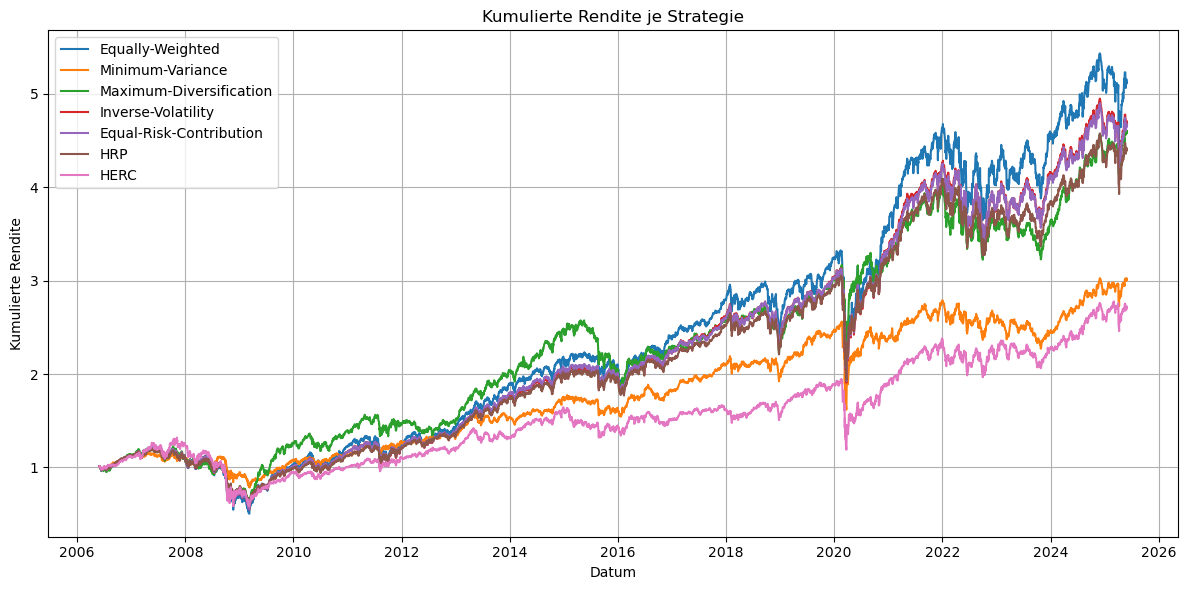

In [20]:
df_SP500["Date"] = pd.to_datetime(df_SP500["Date"])

#Date-Spalte als Index setzen
df_SP500 = df_SP500.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
letzte_returns = kumulative_returns.iloc[-1]
print(letzte_returns)

Equally-Weighted           5.128523
Minimum-Variance           3.019648
Maximum-Diversification    4.597880
Inverse-Volatility         4.694759
Equal-Risk-Contribution    4.664000
HRP                        4.409759
HERC                       2.720552
Name: 2025-05-30 00:00:00, dtype: float64


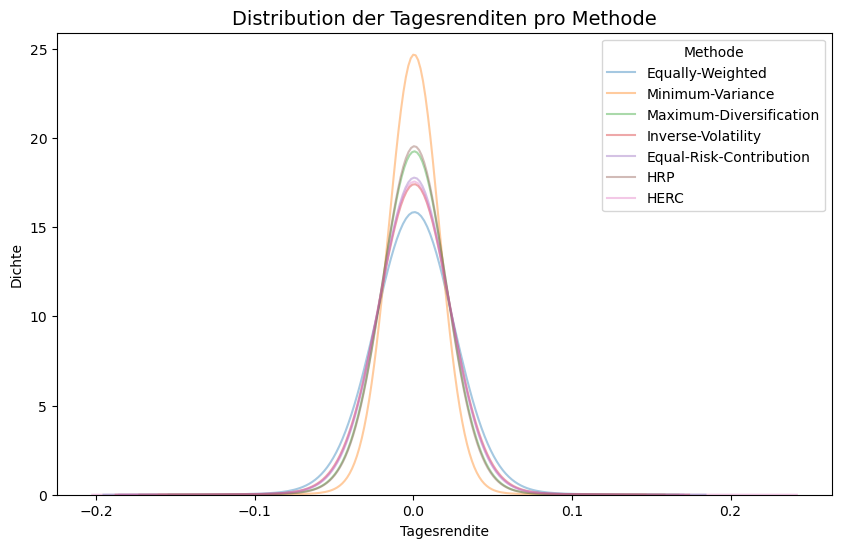

In [22]:
plt.figure(figsize=(10, 6))
for col in df_SP500.columns:
    sb.kdeplot(df_SP500[col], label=col, fill=False, alpha=0.4, bw_adjust=9)

plt.title("Distribution der Tagesrenditen pro Methode", fontsize=14)
plt.xlabel("Tagesrendite")
plt.ylabel("Dichte")
plt.legend(title="Methode")
plt.show()

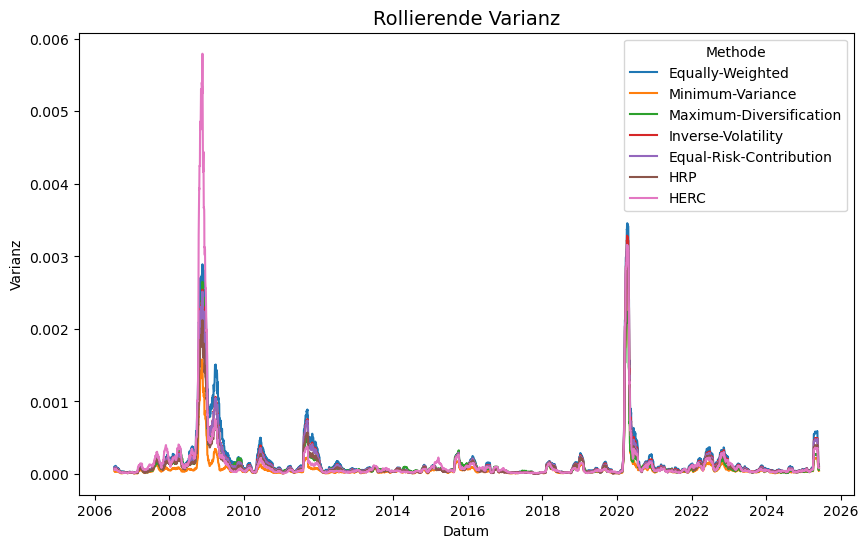

In [23]:
rollierende_varianz = df_SP500.rolling(window=30).var()

plt.figure(figsize=(10, 6))
for col in rollierende_varianz.columns:
    plt.plot(rollierende_varianz.index, rollierende_varianz[col], label=col)

plt.title("Rollierende Varianz", fontsize=14)
plt.xlabel("Datum")
plt.ylabel("Varianz")
plt.legend(title="Methode")
plt.show()

In [24]:
#Letzten Wert jedes Jahres extrahieren
df_kum_endwerte = kumulative_returns.resample('Y').last()

# Jahr als Spalte
df_kum_endwerte.index = df_kum_endwerte.index.year
df_kum_endwerte.index.name = "Jahr"

df_kum_endwerte

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Jahr                                                                
2006          1.114542          1.131163                 1.135232   
2007          1.109205          1.090429                 1.098837   
2008          0.710733          0.942142                 0.769867   
2009          1.018099          1.067293                 1.246614   
2010          1.219180          1.141003                 1.391993   
2011          1.224007          1.273748                 1.458017   
2012          1.416363          1.317923                 1.492369   
2013          1.903130          1.541609                 2.044573   
2014          2.152723          1.725297                 2.450438   
2015          2.069311          1.613315                 2.030925   
2016          2.368636          1.812494                 2.270912   
2017          2.788317          2.095155                 2.556304   
2018          2.543918          1.998755                 2.320228   
2019          3.242763          2.477971                 3.042441   
2020          3.598857          2.388067                 3.216608   
2021          4.633071          2.789866                 4.024094   
2022          4.071534          2.571527                 3.562677   
2023          4.582763          2.450763                 3.606356   
2024          5.079780          2.866549                 4.337321   
2025          5.128523          3.019648                 4.597880   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Jahr                                                                   
2006            1.120755                 1.121112  1.123320  1.112747  
2007            1.108723                 1.110698  1.106826  1.244516  
2008            0.742842                 0.745407  0.772125  0.754815  
2009            0.996020                 1.000413  0.984991  0.938256  
2010            1.161780                 1.159554  1.119800  1.001473  
2011            1.198398                 1.205103  1.204337  1.106578  
2012            1.361098                 1.365098  1.341716  1.188228  
2013            1.788397                 1.804373  1.751640  1.322145  
2014            2.026218                 2.048964  1.988754  1.607978  
2015            1.973582                 1.979256  1.939908  1.429943  
2016            2.217426                 2.219913  2.141061  1.509890  
2017            2.606397                 2.590295  2.512090  1.623165  
2018            2.391988                 2.396769  2.330958  1.566807  
2019            3.039988                 3.032499  2.948778  1.890673  
2020            3.344938                 3.332388  3.255748  1.908536  
2021            4.258982                 4.242756  4.091021  2.378320  
2022            3.779914                 3.791740  3.628856  2.189487  
2023            4.154593                 4.119691  3.840781  2.270003  
2024            4.623819                 4.589832  4.290015  2.597901  
2025            4.694759                 4.664000  4.409759  2.720552

In [25]:
#jährliche kumulierte Rendite berechnen
jährlich_kum_returns = (1 + df_SP500).resample('Y').prod() - 1

# Jahr als Spalte
jährlich_kum_returns.index = jährlich_kum_returns.index.year
jährlich_kum_returns.index.name = "Jahr"

jährlich_kum_returns

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Jahr                                                                
2006          0.114542          0.131163                 0.135232   
2007         -0.004789         -0.036010                -0.032060   
2008         -0.359241         -0.135990                -0.299380   
2009          0.432462          0.132837                 0.619258   
2010          0.197507          0.069063                 0.116619   
2011          0.003959          0.116341                 0.047431   
2012          0.157153          0.034681                 0.023561   
2013          0.343674          0.169726                 0.370018   
2014          0.131149          0.119153                 0.198509   
2015         -0.038747         -0.064906                -0.171199   
2016          0.144650          0.123459                 0.118167   
2017          0.177182          0.155952                 0.125673   
2018         -0.087651         -0.046011                -0.092351   
2019          0.274712          0.239757                 0.311268   
2020          0.109812         -0.036281                 0.057246   
2021          0.287373          0.168253                 0.251036   
2022         -0.121202         -0.078261                -0.114663   
2023          0.125562         -0.046962                 0.012260   
2024          0.108454          0.169656                 0.202688   
2025          0.009596          0.053409                 0.060074   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Jahr                                                                   
2006            0.120755                 0.121112  0.123320  0.112747  
2007           -0.010735                -0.009289 -0.014683  0.118418  
2008           -0.330002                -0.328884 -0.302398 -0.393487  
2009            0.340823                 0.342102  0.275690  0.243028  
2010            0.166423                 0.159076  0.136863  0.067377  
2011            0.031519                 0.039282  0.075492  0.104951  
2012            0.135764                 0.132764  0.114071  0.073785  
2013            0.313938                 0.321791  0.305522  0.112703  
2014            0.132980                 0.135555  0.135367  0.216189  
2015           -0.025978                -0.034021 -0.024561 -0.110720  
2016            0.123554                 0.121589  0.103692  0.055910  
2017            0.175416                 0.166845  0.173292  0.075022  
2018           -0.082263                -0.074712 -0.072104 -0.034721  
2019            0.270904                 0.265244  0.265050  0.206705  
2020            0.100313                 0.098892  0.104101  0.009448  
2021            0.273262                 0.273188  0.256553  0.246149  
2022           -0.112484                -0.106303 -0.112971 -0.079398  
2023            0.099124                 0.086491  0.058400  0.036774  
2024            0.112942                 0.114120  0.116964  0.144448  
2025            0.015342                 0.016159  0.027912  0.047212

In [26]:
from IPython.display import display, HTML

display(HTML(jährlich_kum_returns.to_html()))

In [27]:
reorganisiert = jährlich_kum_returns.reset_index().melt(id_vars="Jahr", var_name="Strategie", value_name="Rendite")
reorganisiert.head()

Jahr         Strategie   Rendite
0  2006  Equally-Weighted  0.114542
1  2007  Equally-Weighted -0.004789
2  2008  Equally-Weighted -0.359241
3  2009  Equally-Weighted  0.432462
4  2010  Equally-Weighted  0.197507

In [28]:
import plotly.express as px

fig = px.bar(reorganisiert, 
             x="Jahr", y="Rendite", color="Strategie", 
             barmode="group",
             text="Rendite",
             title="Jährliche kumulierte Renditen je Strategie",
             color_discrete_sequence=px.colors.qualitative.Vivid)

fig.update_traces(texttemplate='%{text:.1%}', textposition='outside')
fig.update_layout(yaxis_tickformat='.0%', xaxis={'type': 'category'})
fig.show()

In [29]:
#jährliche vola

jährliche_vola = (df_SP500.groupby(df_SP500.index.year).std()
    .apply(lambda x: x * np.sqrt(252))
    * 100
)

jährliche_vola

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         11.066805          7.277586                 9.812227   
2007         16.819596         11.147772                14.596055   
2008         45.256658         27.742128                39.077416   
2009         35.267732         15.751472                26.984587   
2010         20.007178         10.463473                15.078003   
2011         25.657076         12.740272                19.533841   
2012         13.816311          7.572510                11.434013   
2013         12.021780          9.268773                11.249471   
2014         11.637412          8.622668                12.190432   
2015         15.537314         12.491892                16.208685   
2016         14.702485         10.400070                13.762649   
2017          7.205559          5.832779                 7.663202   
2018         15.496869         11.482292                13.480015   
2019         12.466979          8.698633                 9.849589   
2020         39.137727         30.989452                30.135408   
2021         13.749813         10.093847                11.053695   
2022         23.069206         15.081069                17.924686   
2023         14.226479         10.080066                10.920551   
2024         11.444945          7.713465                 8.683074   
2025         23.581986         14.912384                16.332384   

      Inverse-Volatility  Equal-Risk-Contribution        HRP       HERC  
Date                                                                     
2006           10.038318                10.099069   9.136487   8.985038  
2007           16.093688                15.878396  14.634269  19.442027  
2008           40.685003                40.059855  35.724827  52.957998  
2009           29.098052                28.844389  24.104920  23.566671  
2010           17.697244                17.046591  14.945818  13.559621  
2011           23.278636                22.838628  19.871486  16.236465  
2012           12.123221                11.892514  10.243927   9.007660  
2013           11.371117                11.226124  10.636825  11.678466  
2014           11.089277                11.081698  10.588262  10.200962  
2015           15.069961                15.055340  14.587017  16.498374  
2016           13.531964                13.385059  12.599147  13.845574  
2017            6.635873                 6.479273   6.254873   6.560608  
2018           14.802876                14.590451  14.162341  12.601009  
2019           11.512128                10.923121  10.309505   9.594960  
2020           37.218681                36.280670  34.124837  35.363847  
2021           12.569490                11.935890  11.240295  11.214091  
2022           21.451159                20.704720  19.523757  19.472954  
2023           13.184485                12.677744  11.694509  12.055898  
2024           10.690795                10.312009   9.646973   9.703284  
2025           21.790080                21.401793  19.626760  18.797969

<Figure size 1000x600 with 0 Axes>

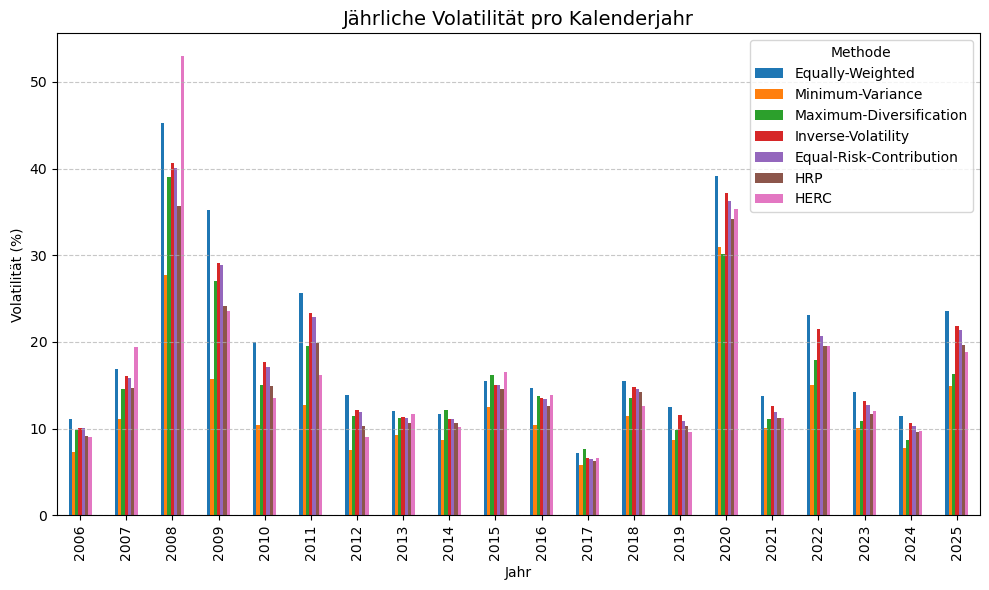

In [30]:
plt.figure(figsize=(10, 6))
jährliche_vola.plot(kind="bar", figsize=(10, 6))

plt.title("Jährliche Volatilität pro Kalenderjahr", fontsize=14)
plt.xlabel("Jahr")
plt.ylabel("Volatilität (%)")
plt.legend(title="Methode")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Sharpe Ratio

In [31]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sharpe_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [32]:
sharpe_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          1.729782          2.930771                 2.258275   
2007          0.055488         -0.275210                -0.151579   
2008         -0.754696         -0.388395                -0.713448   
2009          1.197371          0.872242                 1.926071   
2010          1.002876          0.691899                 0.808592   
2011          0.144039          0.929450                 0.335489   
2012          1.136249          0.492582                 0.262786   
2013          2.523662          1.741577                 2.862081   
2014          1.119485          1.351463                 1.549752   
2015         -0.177152         -0.475690                -1.079220   
2016          0.994499          1.173745                 0.881992   
2017          2.314121          2.529369                 1.592683   
2018         -0.517805         -0.355166                -0.655597   
2019          2.014064          2.520051                 2.807470   
2020          0.463149          0.037936                 0.336463   
2021          1.910362          1.594547                 2.086358   
2022         -0.448169         -0.468151                -0.593748   
2023          0.910888         -0.431580                 0.167238   
2024          0.958833          2.074823                 2.173831   
2025          0.217191          0.940822                 0.968402   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            1.990931                 1.984953  2.220830  2.076793  
2007            0.013087                 0.020364 -0.028446  0.676695  
2008           -0.778726                -0.793027 -0.827397 -0.678430  
2009            1.155514                 1.166465  1.132825  1.043122  
2010            0.960212                 0.953092  0.934827  0.549616  
2011            0.250232                 0.283499  0.466563  0.697235  
2012            1.121356                 1.118309  1.116369  0.843267  
2013            2.463939                 2.547557  2.565848  0.974737  
2014            1.183815                 1.205083  1.254632  1.974099  
2015           -0.099657                -0.155075 -0.097876 -0.629821  
2016            0.930469                 0.926076  0.847742  0.463056  
2017            2.484067                 2.428832  2.602364  1.142173  
2018           -0.509169                -0.462249 -0.460574 -0.219026  
2019            2.145101                 2.213729  2.337660  2.010767  
2020            0.444181                 0.442700  0.461891  0.205744  
2021            1.989480                 2.088101  2.092824  2.023083  
2022           -0.452453                -0.442610 -0.520062 -0.330170  
2023            0.789927                 0.724221  0.548603  0.362691  
2024            1.056545                 1.101786  1.197352  1.442110  
2025            0.281487                 0.292054  0.445749  0.703162

In [33]:
#Durchschnitt
sharpe_durchschnitt = sharpe_jahresweise.mean(axis=1)

sharpe_durchschnitt = sharpe_durchschnitt.to_frame(name="Sharpe_Mittelwert")

sharpe_durchschnitt.info

<bound method DataFrame.info of       Sharpe_Mittelwert
Date                   
2006           2.170333
2007           0.044343
2008          -0.704874
2009           1.213373
2010           0.843016
2011           0.443787
2012           0.870131
2013           2.239914
2014           1.376904
2015          -0.387784
2016           0.888226
2017           2.156230
2018          -0.454227
2019           2.292692
2020           0.341723
2021           1.969251
2022          -0.465052
2023           0.438855
2024           1.429326
2025           0.549838>

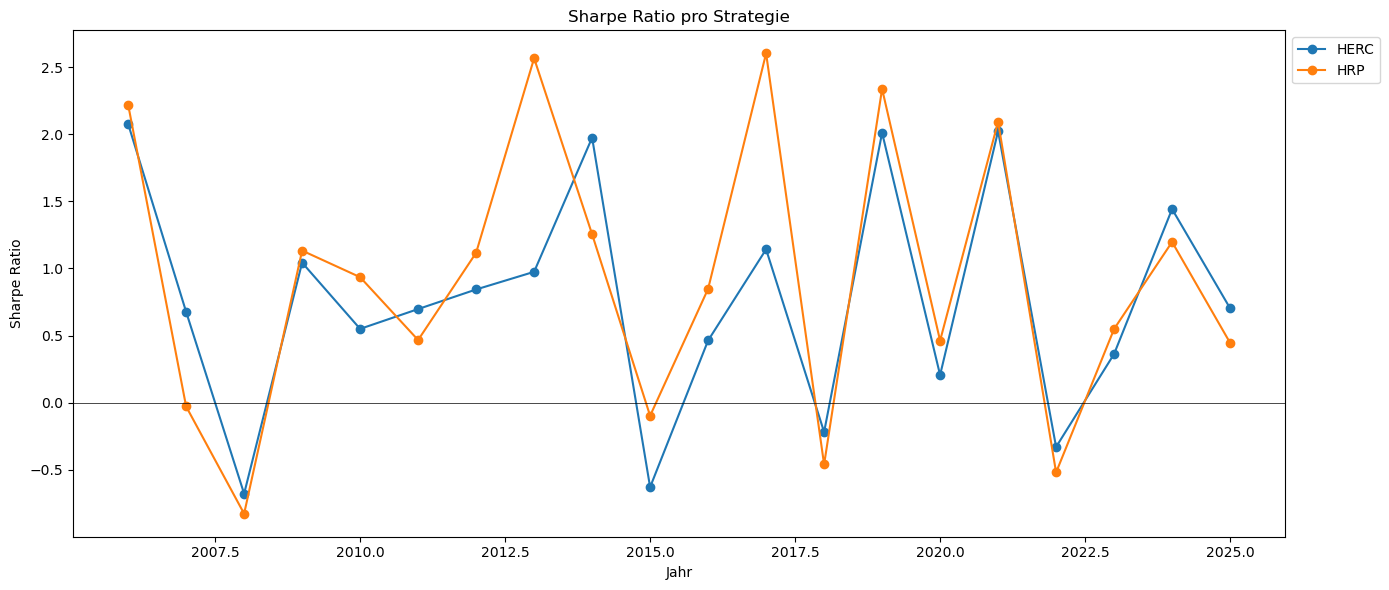

In [34]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "HERC"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

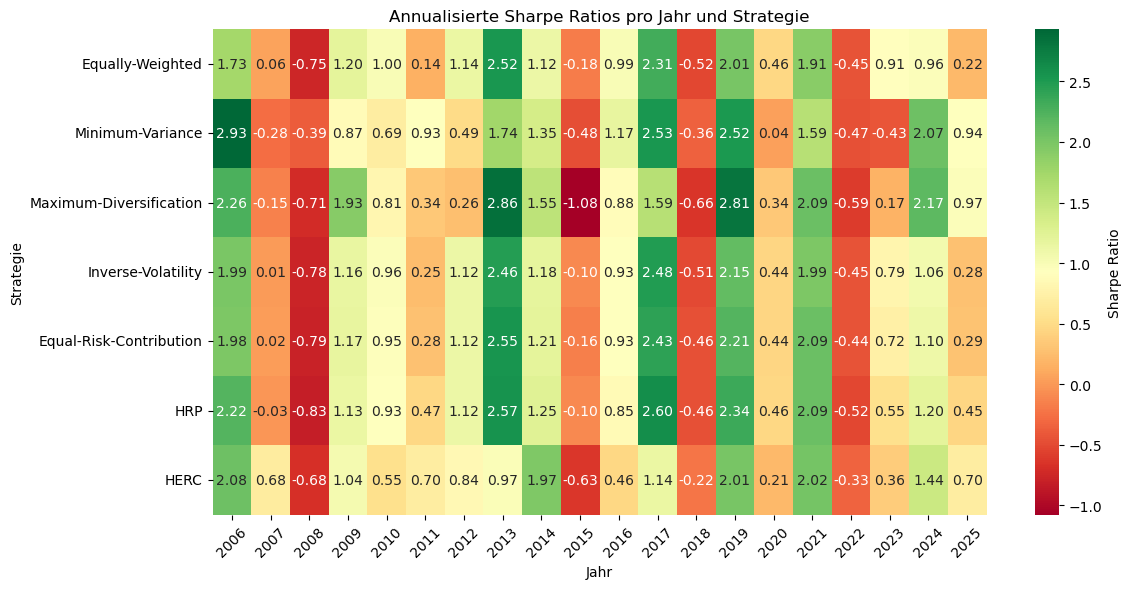

In [35]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                   
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
#Simulation mit synthetischen Werten

np.random.seed(42)

#Simulation: 20 Jahre, 252 Handelstage pro Jahr
years = 20
days_per_year = 252
mu_daily = 0.0005       
sigma_daily = 0.01      

#Simulierte tägliche Renditen (normalverteilt)
daily_returns = np.random.normal(loc=mu_daily, scale=sigma_daily, size=(days_per_year*years,))

#Datum-Index erstellen
dates = pd.date_range(start="2000-01-01", periods=days_per_year*years, freq='B')
df_sim = pd.DataFrame(daily_returns, index=dates, columns=['Strategy'])

#Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    return (returns_daily.mean() / returns_daily.std()) * np.sqrt(days_per_year)

#Sharpe Ratios pro Jahr berechnen
sharpe_by_year = df_sim.groupby(df_sim.index.year).apply(lambda x: x.apply(sharpe_annual))

print(sharpe_by_year)

      Strategy
2000  0.938821
2001  0.686188
2002  0.254476
2003  3.547887
2004  1.809797
2005  2.077011
2006  1.241718
2007  0.797057
2008  1.363644
2009  0.511714
2010  2.034882
2011 -0.234316
2012  0.727365
2013  1.306639
2014 -0.508489
2015  0.455300
2016 -1.627256
2017  1.034871
2018  0.593904
2019  2.021202


In [37]:
# Funktion für annualisierten Sharpe Ratio
def sharpe_annual(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

# Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe = df_SP500.apply(sharpe_annual)

print(gesamt_sharpe)

Equally-Weighted           0.506756
Minimum-Variance           0.486987
Maximum-Diversification    0.541717
Inverse-Volatility         0.512747
Equal-Risk-Contribution    0.517460
HRP                        0.533841
HERC                       0.365604
dtype: float64


#### Sortino

In [38]:
df_SP500.index = pd.to_datetime(df_SP500.index)
sortino_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

In [39]:
sortino_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.792660          4.730628                 3.564362   
2007          0.073759         -0.366495                -0.202751   
2008         -1.040930         -0.569794                -0.983664   
2009          1.788247          1.246456                 2.909076   
2010          1.454498          0.956818                 1.114317   
2011          0.196622          1.323396                 0.461107   
2012          1.716659          0.687180                 0.373816   
2013          3.791554          2.547758                 4.396478   
2014          1.559121          1.958459                 2.281227   
2015         -0.244847         -0.630480                -1.415784   
2016          1.405623          1.715060                 1.307812   
2017          3.612319          3.835802                 2.324149   
2018         -0.673169         -0.466695                -0.862299   
2019          2.902746          3.901818                 4.262934   
2020          0.636059          0.050176                 0.454176   
2021          2.863598          2.409639                 3.114532   
2022         -0.629336         -0.634950                -0.801737   
2023          1.354566         -0.585159                 0.232339   
2024          1.360373          3.096591                 3.392489   
2025          0.318724          1.352779                 1.410706   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.273596                 3.253105  3.684113  3.444168  
2007            0.017360                 0.026936 -0.037620  0.908300  
2008           -1.077928                -1.096203 -1.148175 -0.962607  
2009            1.708957                 1.724293  1.661851  1.495002  
2010            1.389670                 1.375533  1.342011  0.781323  
2011            0.342211                 0.387758  0.640337  0.973537  
2012            1.688590                 1.681649  1.679661  1.289583  
2013            3.727032                 3.851547  3.904850  1.431353  
2014            1.657092                 1.687974  1.756329  3.023083  
2015           -0.137929                -0.214015 -0.134996 -0.828022  
2016            1.314337                 1.312877  1.199584  0.627020  
2017            3.906518                 3.801948  4.067048  1.656208  
2018           -0.658937                -0.598997 -0.593810 -0.291282  
2019            3.105232                 3.217216  3.430484  3.033469  
2020            0.606772                 0.601648  0.627475  0.274665  
2021            2.970522                 3.126664  3.116841  3.023341  
2022           -0.634774                -0.618892 -0.720906 -0.462497  
2023            1.161154                 1.060140  0.793756  0.528714  
2024            1.509385                 1.577304  1.718547  2.099436  
2025            0.409308                 0.425075  0.645173  0.988961

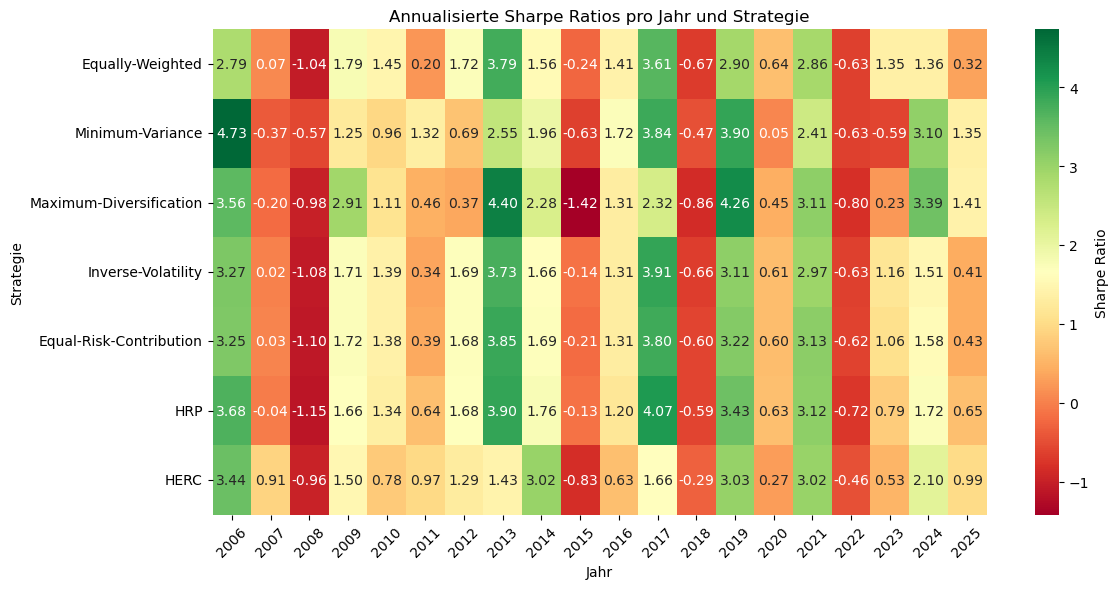

In [40]:
plt.figure(figsize=(12,6))
sb.heatmap(sortino_jahresweise.T,        
            annot=True,                  
            fmt=".2f",                  
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'}) 

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

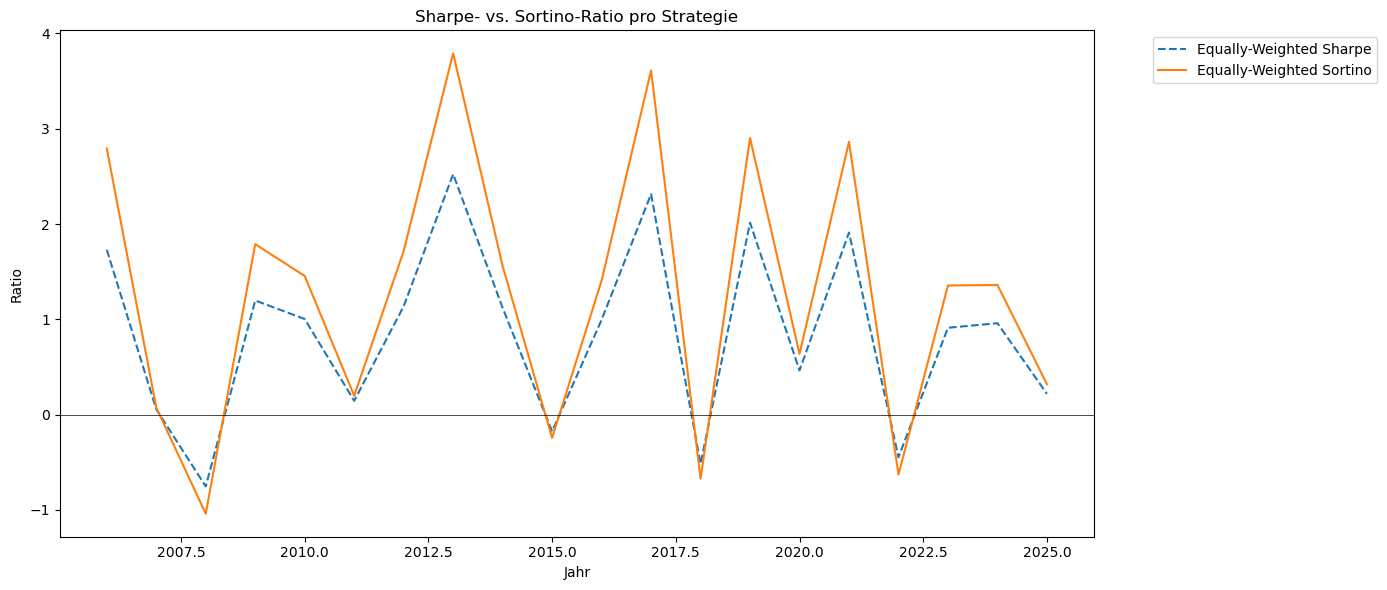

In [41]:
#Vergleich Sharpe und Sortino
strategies = sharpe_jahresweise.columns
jahre = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Equally-Weighted"

plt.plot(jahre, sharpe_jahresweise[strategie], label=f"{strategie} Sharpe", linestyle='--')
plt.plot(jahre, sortino_jahresweise[strategie], label=f"{strategie} Sortino", linestyle='-')

plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Jahr")
plt.ylabel("Ratio")
plt.title("Sharpe- vs. Sortino-Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [42]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino = df_SP500.apply(sortino_annual)

print(gesamt_sortino)

Equally-Weighted           0.714591
Minimum-Variance           0.679664
Maximum-Diversification    0.759214
Inverse-Volatility         0.720360
Equal-Risk-Contribution    0.725708
HRP                        0.747084
HERC                       0.511900
dtype: float64


#### Maximum Drawdown

In [43]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(maximum_drawdown))

In [44]:
max_drawdown_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.052741         -0.032493                -0.059273   
2007         -0.120993         -0.086033                -0.118829   
2008         -0.514100         -0.245983                -0.455803   
2009         -0.330099         -0.172797                -0.231632   
2010         -0.161364         -0.074240                -0.137344   
2011         -0.223597         -0.094860                -0.147362   
2012         -0.110339         -0.048312                -0.109594   
2013         -0.064620         -0.069581                -0.059474   
2014         -0.078686         -0.050567                -0.060753   
2015         -0.126825         -0.121017                -0.225267   
2016         -0.100436         -0.090955                -0.078556   
2017         -0.029413         -0.033924                -0.042833   
2018         -0.197354         -0.122874                -0.188439   
2019         -0.069854         -0.037208                -0.050986   
2020         -0.402555         -0.368339                -0.311323   
2021         -0.064159         -0.066575                -0.059777   
2022         -0.219862         -0.149925                -0.194874   
2023         -0.138006         -0.136012                -0.120184   
2024         -0.073563         -0.058303                -0.062637   
2025         -0.159312         -0.084803                -0.097921   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.045347                -0.046826 -0.040843 -0.037846  
2007           -0.115611                -0.115236 -0.103573 -0.134990  
2008           -0.468779                -0.464696 -0.414811 -0.527072  
2009           -0.294486                -0.292586 -0.262105 -0.258747  
2010           -0.140038                -0.133027 -0.113187 -0.084708  
2011           -0.192493                -0.186840 -0.155081 -0.124246  
2012           -0.086786                -0.083773 -0.064328 -0.062289  
2013           -0.064324                -0.063043 -0.063964 -0.111121  
2014           -0.071935                -0.072412 -0.066238 -0.048868  
2015           -0.114568                -0.115996 -0.107299 -0.193364  
2016           -0.088944                -0.087552 -0.078442 -0.095391  
2017           -0.025714                -0.023213 -0.021804 -0.043010  
2018           -0.185918                -0.181958 -0.174355 -0.115712  
2019           -0.059479                -0.056026 -0.047223 -0.048321  
2020           -0.391137                -0.384757 -0.366611 -0.387935  
2021           -0.057669                -0.056028 -0.056623 -0.065266  
2022           -0.208779                -0.200432 -0.200981 -0.165744  
2023           -0.129217                -0.125239 -0.120620 -0.126062  
2024           -0.073719                -0.071057 -0.067907 -0.065816  
2025           -0.140928                -0.138911 -0.121817 -0.114329

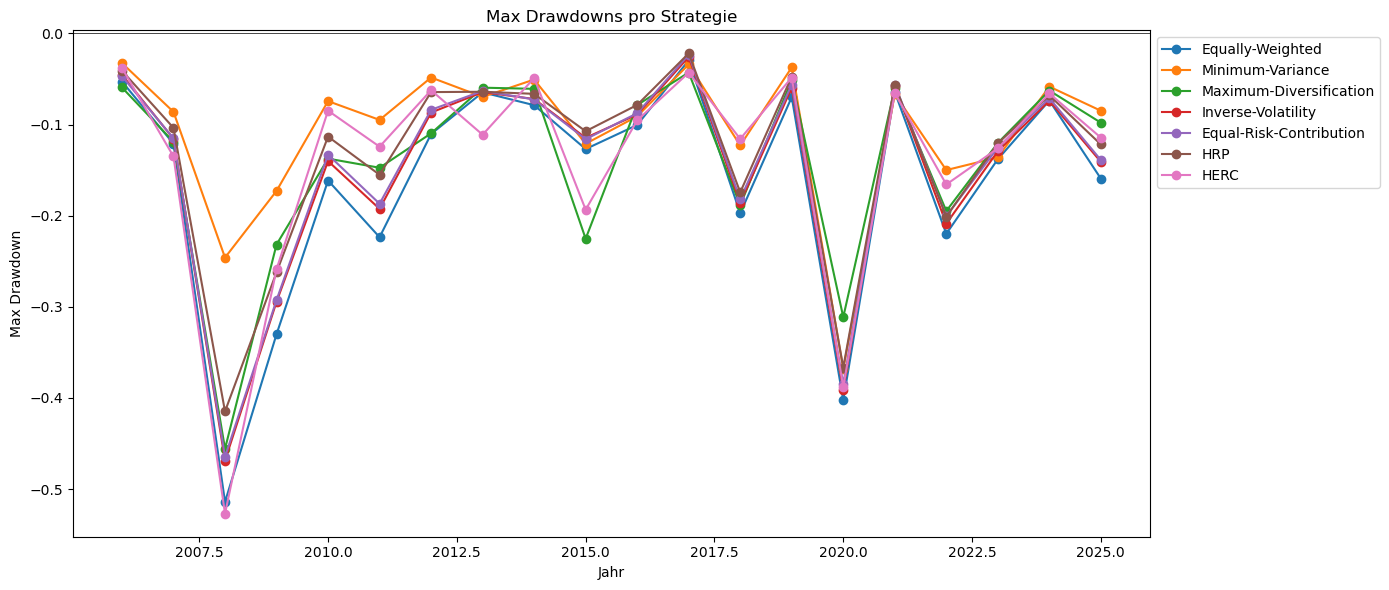

In [45]:
#Plotten der MDDs
strategien = max_drawdown_jahresweise.columns
years = max_drawdown_jahresweise.index

plt.figure(figsize=(14,6))

for strategie in strategies:
    plt.plot(years, max_drawdown_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  # Null-Linie
plt.xlabel("Jahr")
plt.ylabel("Max Drawdown")
plt.title("Max Drawdowns pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
df_SP500.index = pd.to_datetime(df_SP500.index)
max_drawdown_total = df_SP500.apply(maximum_drawdown)

max_drawdown_total.info

<bound method Series.info of Equally-Weighted          -0.587906
Minimum-Variance          -0.368339
Maximum-Diversification   -0.509112
Inverse-Volatility        -0.548714
Equal-Risk-Contribution   -0.547576
HRP                       -0.509603
HERC                      -0.558920
dtype: float64>

#### Calmar Ratio

In [47]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(calmar_ratio_total))

In [48]:
calmar_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.171776          4.036638                 2.281507   
2007         -0.039582         -0.418561                -0.269798   
2008         -0.698776         -0.552841                -0.656818   
2009          1.310099          0.768747                 2.673461   
2010          1.223985          0.930266                 0.849105   
2011          0.017706          1.226454                 0.321870   
2012          1.424275          0.717846                 0.214983   
2013          5.318381          2.439253                 6.221534   
2014          1.666729          2.356353                 3.267488   
2015         -0.305519         -0.536333                -0.759982   
2016          1.440215          1.357371                 1.504229   
2017          6.023956          4.597129                 2.934018   
2018         -0.444132         -0.374457                -0.490082   
2019          3.932656          6.443662                 6.105010   
2020          0.272787         -0.098500                 0.183879   
2021          4.479063          2.527273                 4.199529   
2022         -0.551263         -0.522005                -0.588398   
2023          0.909829         -0.345278                 0.102012   
2024          1.474288          2.909876                 3.235920   
2025          0.060231          0.629796                 0.613494   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.662913                 2.586416  3.019351  2.979091  
2007           -0.092859                -0.080605 -0.141762  0.877236  
2008           -0.703960                -0.707740 -0.729001 -0.746552  
2009            1.157351                 1.169236  1.051828  0.939248  
2010            1.188413                 1.195818  1.209183  0.795396  
2011            0.163739                 0.210242  0.486792  0.844701  
2012            1.564352                 1.584811  1.773277  1.184567  
2013            4.880562                 5.104330  4.776499  1.014236  
2014            1.848609                 1.871981  2.043647  4.423904  
2015           -0.226747                -0.293296 -0.228903 -0.572597  
2016            1.389132                 1.388763  1.321896  0.586106  
2017            6.821712                 7.187706  7.947815  1.744279  
2018           -0.442466                -0.410599 -0.413549 -0.300065  
2019            4.554649                 4.734302  5.612770  4.277727  
2020            0.256465                 0.257024  0.283954  0.024355  
2021            4.738472                 4.875951  4.530901  3.771489  
2022           -0.538772                -0.530367 -0.562097 -0.479038  
2023            0.767109                 0.690608  0.484168  0.291713  
2024            1.532058                 1.606046  1.722405  2.194721  
2025            0.108866                 0.116328  0.229133  0.412944

In [49]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total = df_SP500.apply(calmar_ratio)

calmar_total.info

<bound method Series.info of Equally-Weighted           0.153103
Minimum-Variance           0.162875
Maximum-Diversification    0.164506
Inverse-Volatility         0.154805
Equal-Risk-Contribution    0.154440
HRP                        0.159668
HERC                       0.096938
dtype: float64>

In [50]:
df_SP500.index = pd.to_datetime(df_SP500.index)
calmar_total_2 = df_SP500.apply(calmar_ratio_total)

calmar_total_2.info

<bound method Series.info of Equally-Weighted           7.022426
Minimum-Variance           5.483121
Maximum-Diversification    7.066972
Inverse-Volatility         6.733484
Equal-Risk-Contribution    6.691313
HRP                        6.691004
HERC                       3.078350
dtype: float64>

#### Value at Risk

In [51]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.010491         -0.006437                -0.009906   
2007         -0.020293         -0.012827                -0.016506   
2008         -0.048328         -0.028963                -0.045635   
2009         -0.034872         -0.017711                -0.029043   
2010         -0.019272         -0.010251                -0.015252   
2011         -0.027043         -0.011240                -0.020326   
2012         -0.013114         -0.007695                -0.011185   
2013         -0.012335         -0.008617                -0.010313   
2014         -0.012410         -0.009774                -0.013133   
2015         -0.015875         -0.012931                -0.016462   
2016         -0.015706         -0.010797                -0.013968   
2017         -0.006222         -0.005594                -0.007119   
2018         -0.019202         -0.012682                -0.015068   
2019         -0.011874         -0.008187                -0.009593   
2020         -0.035474         -0.023664                -0.022255   
2021         -0.013917         -0.009378                -0.011082   
2022         -0.023897         -0.015195                -0.018692   
2023         -0.014492         -0.011321                -0.011192   
2024         -0.011338         -0.007592                -0.008244   
2025         -0.019414         -0.012012                -0.012150   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.009115                -0.009143 -0.007912 -0.008160  
2007           -0.019878                -0.019595 -0.017755 -0.022447  
2008           -0.042925                -0.042077 -0.038754 -0.053915  
2009           -0.028652                -0.028647 -0.025073 -0.024064  
2010           -0.017349                -0.016702 -0.014518 -0.013911  
2011           -0.023845                -0.023462 -0.019302 -0.015290  
2012           -0.011419                -0.011245 -0.010320 -0.008283  
2013           -0.011099                -0.011208 -0.010241 -0.012320  
2014           -0.011631                -0.011583 -0.011050 -0.009708  
2015           -0.015763                -0.015541 -0.015340 -0.017484  
2016           -0.014528                -0.014025 -0.013873 -0.015318  
2017           -0.005616                -0.005588 -0.005332 -0.007022  
2018           -0.018655                -0.018396 -0.017550 -0.012919  
2019           -0.010516                -0.010189 -0.009652 -0.009414  
2020           -0.031988                -0.030977 -0.028907 -0.028443  
2021           -0.012448                -0.011934 -0.011629 -0.010833  
2022           -0.022039                -0.021462 -0.019890 -0.021008  
2023           -0.013847                -0.013313 -0.012067 -0.013315  
2024           -0.009988                -0.010017 -0.009709 -0.008790  
2025           -0.018100                -0.018256 -0.016628 -0.016655

In [52]:
df_SP500.index = pd.to_datetime(df_SP500.index)
var_total = df_SP500.apply(value_at_risk_func)

var_total.info

<bound method Series.info of Equally-Weighted          -0.019831
Minimum-Variance          -0.012082
Maximum-Diversification   -0.015886
Inverse-Volatility        -0.018033
Equal-Risk-Contribution   -0.017721
HRP                       -0.015932
HERC                      -0.016347
dtype: float64>

In [53]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var = monthly_returns.apply(value_at_risk_func)

monthly_var.info

<bound method Series.info of Equally-Weighted          -0.080061
Minimum-Variance          -0.048721
Maximum-Diversification   -0.060691
Inverse-Volatility        -0.071138
Equal-Risk-Contribution   -0.068443
HRP                       -0.061486
HERC                      -0.063546
dtype: float64>

#### Expected Shortfall

In [54]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_jahresweise = df_SP500.groupby(df_SP500.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.013409         -0.009072                -0.012484   
2007         -0.026440         -0.017307                -0.021303   
2008         -0.069430         -0.041833                -0.060675   
2009         -0.049169         -0.022357                -0.036345   
2010         -0.029270         -0.015882                -0.022756   
2011         -0.038664         -0.018052                -0.027943   
2012         -0.018481         -0.010921                -0.015148   
2013         -0.016722         -0.013174                -0.014966   
2014         -0.017617         -0.011834                -0.017117   
2015         -0.022330         -0.018313                -0.024461   
2016         -0.022342         -0.014109                -0.017514   
2017         -0.009567         -0.007944                -0.010707   
2018         -0.025532         -0.018451                -0.020699   
2019         -0.019292         -0.011899                -0.014101   
2020         -0.062049         -0.052952                -0.049309   
2021         -0.019178         -0.013866                -0.015687   
2022         -0.031751         -0.021030                -0.024666   
2023         -0.017626         -0.014288                -0.014489   
2024         -0.016385         -0.010269                -0.011069   
2025         -0.033206         -0.019044                -0.021719   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.011910                -0.012160 -0.010857 -0.010845  
2007           -0.025422                -0.025082 -0.023027 -0.029378  
2008           -0.062363                -0.061479 -0.054438 -0.083431  
2009           -0.041238                -0.040996 -0.034342 -0.035932  
2010           -0.026043                -0.025129 -0.022232 -0.020300  
2011           -0.035256                -0.034649 -0.030112 -0.023417  
2012           -0.016338                -0.015996 -0.013621 -0.010736  
2013           -0.015683                -0.015549 -0.014732 -0.015816  
2014           -0.016696                -0.016648 -0.015931 -0.013506  
2015           -0.021449                -0.021570 -0.020739 -0.025383  
2016           -0.020461                -0.020145 -0.018787 -0.021002  
2017           -0.008871                -0.008677 -0.008410 -0.008906  
2018           -0.024722                -0.024221 -0.023553 -0.019827  
2019           -0.017857                -0.016788 -0.015695 -0.013645  
2020           -0.060061                -0.058860 -0.055964 -0.058982  
2021           -0.018052                -0.017118 -0.016233 -0.015937  
2022           -0.029449                -0.028388 -0.026721 -0.025541  
2023           -0.016694                -0.016053 -0.015167 -0.015557  
2024           -0.014908                -0.014430 -0.013054 -0.012941  
2025           -0.030525                -0.029988 -0.026780 -0.026247

In [55]:
df_SP500.index = pd.to_datetime(df_SP500.index)
es_total = df_SP500.apply(expected_shortfall)

es_total.info

<bound method Series.info of Equally-Weighted          -0.033307
Minimum-Variance          -0.020342
Maximum-Diversification   -0.026755
Inverse-Volatility        -0.030262
Equal-Risk-Contribution   -0.029673
HRP                       -0.026852
HERC                      -0.029516
dtype: float64>

In [56]:
monthly_returns = df_SP500.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es  = monthly_returns.apply(expected_shortfall)

monthly_es.info

<bound method Series.info of Equally-Weighted          -0.112451
Minimum-Variance          -0.075460
Maximum-Diversification   -0.092477
Inverse-Volatility        -0.102406
Equal-Risk-Contribution   -0.100891
HRP                       -0.092260
HERC                      -0.101776
dtype: float64>

In [57]:
yearly_returns = df_SP500.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es  = yearly_returns.apply(expected_shortfall)

yearly_es.info

<bound method Series.info of Equally-Weighted          -0.359241
Minimum-Variance          -0.135990
Maximum-Diversification   -0.299380
Inverse-Volatility        -0.330002
Equal-Risk-Contribution   -0.328884
HRP                       -0.302398
HERC                      -0.393487
dtype: float64>

In [58]:
#Zusammenfassung der Metriken
Zusammenfassung = pd.concat([gesamt_sharpe, gesamt_sortino, max_drawdown_total, calmar_total_2, monthly_var, monthly_es], axis=1)
Zusammenfassung.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var_M", "ES_M"]
print(Zusammenfassung)

                           Sharpe   Sortino  Max Drawdown    Calmar     Var_M  \
Equally-Weighted         0.506756  0.714591     -0.587906  7.022426 -0.080061   
Minimum-Variance         0.486987  0.679664     -0.368339  5.483121 -0.048721   
Maximum-Diversification  0.541717  0.759214     -0.509112  7.066972 -0.060691   
Inverse-Volatility       0.512747  0.720360     -0.548714  6.733484 -0.071138   
Equal-Risk-Contribution  0.517460  0.725708     -0.547576  6.691313 -0.068443   
HRP                      0.533841  0.747084     -0.509603  6.691004 -0.061486   
HERC                     0.365604  0.511900     -0.558920  3.078350 -0.063546   

                             ES_M  
Equally-Weighted        -0.112451  
Minimum-Variance        -0.075460  
Maximum-Diversification -0.092477  
Inverse-Volatility      -0.102406  
Equal-Risk-Contribution -0.100891  
HRP                     -0.092260  
HERC                    -0.101776  


## S&P 500 mit Ledoit-Shrinkage

In [59]:
#Bearbeitete SP500-Daten (Gesamtbestand)

df_SP500_shrinked = pd.read_csv(
    'returnssp500shrinked_2Monate_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [60]:
df_SP500_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.012900          0.010584                 0.010986   
1     2006-06-02          0.001590          0.000545                 0.001427   
2     2006-06-05         -0.019401         -0.011641                -0.015187   
3     2006-06-06         -0.002777          0.002887                -0.002299   
4     2006-06-07         -0.005689         -0.000096                -0.000634   
...          ...               ...               ...                      ...   
4775  2025-05-23         -0.003963          0.000394                 0.000951   
4776  2025-05-27          0.018495          0.009625                 0.009714   
4777  2025-05-28         -0.008845         -0.007372                -0.006995   
4778  2025-05-29          0.003775          0.002789                 0.001990   
4779  2025-05-30         -0.000470          0.003427                 0.003763

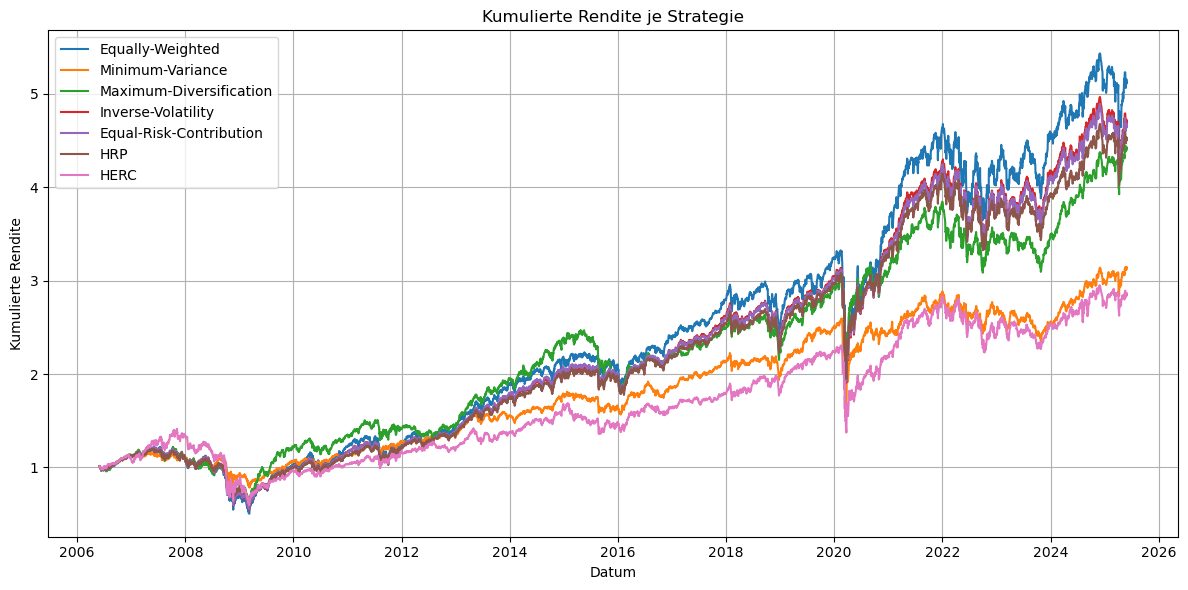

In [61]:
df_SP500_shrinked["Date"] = pd.to_datetime(df_SP500_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_shrinked = df_SP500_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sharpe_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

In [63]:
sharpe_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          1.729782          2.907280                 2.291615   
2007          0.055488         -0.203072                -0.140580   
2008         -0.754696         -0.458057                -0.723511   
2009          1.197371          0.909742                 1.861476   
2010          1.002876          0.714832                 0.809432   
2011          0.144039          0.967722                 0.351482   
2012          1.136249          0.592399                 0.266527   
2013          2.523662          1.796102                 2.809586   
2014          1.119485          1.452563                 1.609147   
2015         -0.177152         -0.519526                -1.066555   
2016          0.994499          1.226136                 0.915224   
2017          2.314121          2.538181                 1.693726   
2018         -0.517805         -0.424993                -0.664625   
2019          2.014064          2.627263                 2.807243   
2020          0.463149          0.063634                 0.321673   
2021          1.910362          1.701324                 2.067178   
2022         -0.448169         -0.460545                -0.578520   
2023          0.910888         -0.406613                 0.161368   
2024          0.958833          2.098890                 2.233292   
2025          0.217191          0.953342                 0.994299   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            1.965206                 1.925440  2.176701  1.713948  
2007            0.017294                 0.023647 -0.013061  1.089833  
2008           -0.779605                -0.793314 -0.813990 -0.554337  
2009            1.155133                 1.166842  1.151809  0.531250  
2010            0.962131                 0.951748  0.910165  0.644755  
2011            0.244170                 0.283458  0.458903  0.784582  
2012            1.123787                 1.120456  1.085947  0.328961  
2013            2.469294                 2.547532  2.570712  1.304786  
2014            1.178183                 1.212510  1.271044  1.646222  
2015           -0.104230                -0.143477 -0.079377 -0.559033  
2016            0.932488                 0.914244  0.895073  0.930429  
2017            2.475939                 2.422046  2.569085  1.352820  
2018           -0.508031                -0.479490 -0.467213  0.299452  
2019            2.135170                 2.222613  2.360382  2.130105  
2020            0.445919                 0.446361  0.465200  0.133349  
2021            1.983130                 2.086193  2.116024  2.113900  
2022           -0.453261                -0.443630 -0.488038 -0.789468  
2023            0.796545                 0.725422  0.560496  0.425597  
2024            1.047876                 1.100459  1.195485  0.709723  
2025            0.267223                 0.300865  0.483214  0.655807

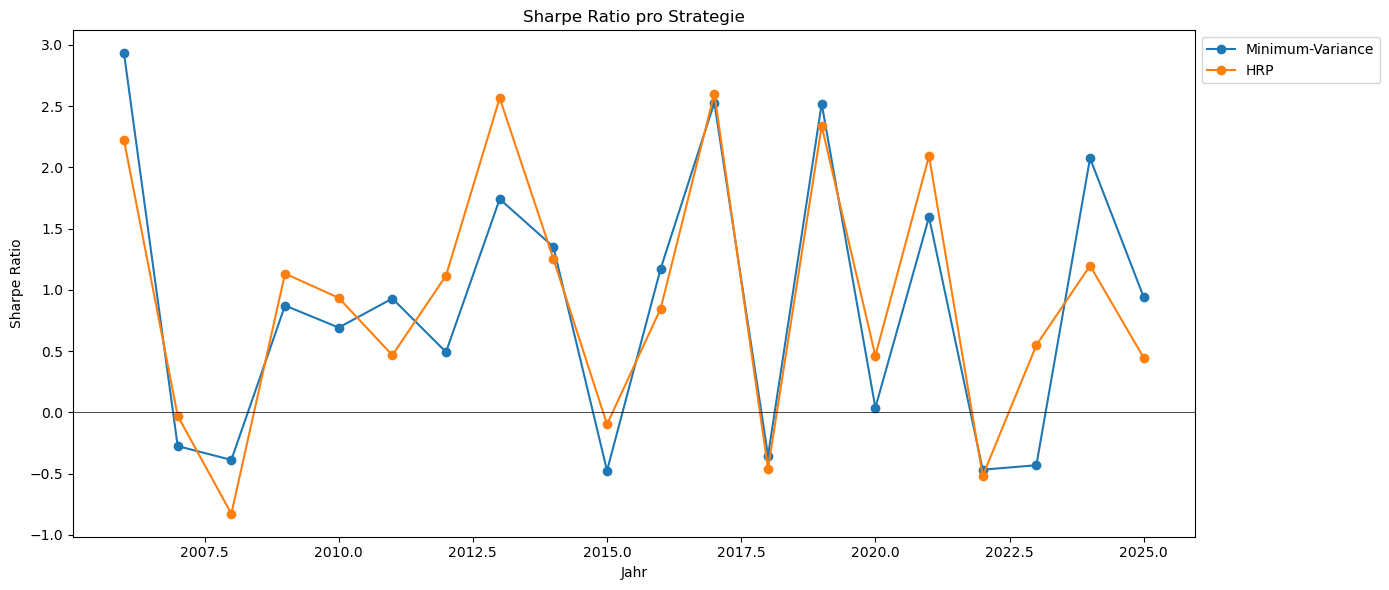

In [64]:
#Plotten der SR
strategien = sharpe_jahresweise.columns
years = sharpe_jahresweise.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [65]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
gesamt_sharpe_shrinked = df_SP500_shrinked.apply(sharpe_annual)

print(gesamt_sharpe_shrinked)

Equally-Weighted           0.506756
Minimum-Variance           0.503995
Maximum-Diversification    0.541366
Inverse-Volatility         0.511276
Equal-Risk-Contribution    0.516922
HRP                        0.541613
HERC                       0.374111
dtype: float64


#### Sortino Ratio

In [66]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
sortino_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.792660          4.738232                 3.631802   
2007          0.073759         -0.271041                -0.187750   
2008         -1.040930         -0.669464                -1.000857   
2009          1.788247          1.298425                 2.784540   
2010          1.454498          0.991459                 1.116290   
2011          0.196622          1.376613                 0.481612   
2012          1.716659          0.838245                 0.379552   
2013          3.791554          2.634439                 4.301747   
2014          1.559121          2.111075                 2.369870   
2015         -0.244847         -0.688659                -1.399421   
2016          1.405623          1.800578                 1.359841   
2017          3.612319          3.859135                 2.495441   
2018         -0.673169         -0.555229                -0.869643   
2019          2.902746          4.089495                 4.253427   
2020          0.636059          0.084144                 0.430643   
2021          2.863598          2.551218                 3.084260   
2022         -0.629336         -0.624218                -0.781666   
2023          1.354566         -0.552638                 0.223446   
2024          1.360373          3.143355                 3.488623   
2025          0.318724          1.372014                 1.448315   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.226751                 3.149743  3.599954  2.672239  
2007            0.022941                 0.031280 -0.017283  1.483366  
2008           -1.078547                -1.096581 -1.130903 -0.783468  
2009            1.708753                 1.724892  1.691987  0.739026  
2010            1.392517                 1.373481  1.304843  0.916156  
2011            0.333899                 0.387704  0.630150  1.104441  
2012            1.692553                 1.685256  1.627459  0.487292  
2013            3.733273                 3.851486  3.920166  1.929101  
2014            1.648476                 1.698570  1.782814  2.440656  
2015           -0.144233                -0.198085 -0.109662 -0.737069  
2016            1.317100                 1.294561  1.270137  1.316643  
2017            3.892499                 3.790378  4.022621  2.017659  
2018           -0.657740                -0.621112 -0.603042  0.400974  
2019            3.089530                 3.230740  3.478605  3.222714  
2020            0.609497                 0.607254  0.632032  0.178759  
2021            2.961926                 3.125263  3.150324  3.182091  
2022           -0.635899                -0.620299 -0.677424 -1.060689  
2023            1.171669                 1.062537  0.812717  0.623162  
2024            1.496170                 1.574982  1.719993  0.986734  
2025            0.388946                 0.438073  0.701540  0.938413

In [67]:

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_shrinked = df_SP500_shrinked.apply(sortino_annual)

print(gesamt_sortino_shrinked)

Equally-Weighted           0.714591
Minimum-Variance           0.702833
Maximum-Diversification    0.756426
Inverse-Volatility         0.718376
Equal-Risk-Contribution    0.725094
HRP                        0.758650
HERC                       0.522039
dtype: float64


In [68]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.052741         -0.032279                -0.054051   
2007         -0.120993         -0.080644                -0.114037   
2008         -0.514100         -0.248956                -0.432434   
2009         -0.330099         -0.164348                -0.221062   
2010         -0.161364         -0.075198                -0.130442   
2011         -0.223597         -0.093238                -0.142871   
2012         -0.110339         -0.048109                -0.097462   
2013         -0.064620         -0.069741                -0.060360   
2014         -0.078686         -0.049758                -0.058220   
2015         -0.126825         -0.124703                -0.220199   
2016         -0.100436         -0.091127                -0.076672   
2017         -0.029413         -0.033179                -0.040021   
2018         -0.197354         -0.129797                -0.184002   
2019         -0.069854         -0.036979                -0.047437   
2020         -0.402555         -0.368336                -0.322204   
2021         -0.064159         -0.066119                -0.061860   
2022         -0.219862         -0.154821                -0.193922   
2023         -0.138006         -0.136623                -0.119160   
2024         -0.073563         -0.056281                -0.058968   
2025         -0.159312         -0.085850                -0.092814   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.046101                -0.048022 -0.039830 -0.038872  
2007           -0.116304                -0.114966 -0.102905 -0.108401  
2008           -0.473354                -0.465242 -0.413870 -0.518875  
2009           -0.296861                -0.292563 -0.259793 -0.337824  
2010           -0.141540                -0.133288 -0.113908 -0.081661  
2011           -0.194471                -0.186853 -0.155520 -0.119213  
2012           -0.087781                -0.083602 -0.064325 -0.089331  
2013           -0.064243                -0.063051 -0.063653 -0.118982  
2014           -0.072488                -0.071880 -0.064755 -0.045797  
2015           -0.115162                -0.116015 -0.106623 -0.194178  
2016           -0.089569                -0.088836 -0.076886 -0.073989  
2017           -0.026037                -0.023213 -0.023703 -0.045610  
2018           -0.187130                -0.184450 -0.174112 -0.109660  
2019           -0.060285                -0.056040 -0.047490 -0.037443  
2020           -0.391868                -0.384087 -0.366913 -0.404199  
2021           -0.058321                -0.055302 -0.057948 -0.068611  
2022           -0.209537                -0.200654 -0.197481 -0.211554  
2023           -0.129668                -0.125517 -0.120937 -0.129758  
2024           -0.073858                -0.071814 -0.068031 -0.085305  
2025           -0.143345                -0.138828 -0.121758 -0.098656

In [69]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
max_drawdown_total_shrinked = df_SP500_shrinked.apply(maximum_drawdown)

max_drawdown_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.587906
Minimum-Variance          -0.368336
Maximum-Diversification   -0.487901
Inverse-Volatility        -0.552149
Equal-Risk-Contribution   -0.547711
HRP                       -0.505222
HERC                      -0.578101
dtype: float64>

#### Calmar Ratio

In [70]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.171776          3.988967                 2.450059   
2007         -0.039582         -0.353183                -0.260302   
2008         -0.698776         -0.601906                -0.663490   
2009          1.310099          0.829249                 2.455851   
2010          1.223985          0.957718                 0.869154   
2011          0.017706          1.314931                 0.346259   
2012          1.424275          0.872574                 0.237938   
2013          5.318381          2.493800                 5.882822   
2014          1.666729          2.594103                 3.470584   
2015         -0.305519         -0.563647                -0.758704   
2016          1.440215          1.403212                 1.587976   
2017          6.023956          4.593218                 3.219599   
2018         -0.444132         -0.416708                -0.502866   
2019          3.932656          6.772174                 6.469956   
2020          0.272787         -0.076581                 0.162882   
2021          4.479063          2.713606                 3.893311   
2022         -0.551263         -0.499599                -0.574473   
2023          0.909829         -0.322882                 0.097050   
2024          1.474288          3.026822                 3.485950   
2025          0.060231          0.635402                 0.660653   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.609228                 2.484457  3.025366  2.556847  
2007           -0.087409                -0.076410 -0.121754  2.016185  
2008           -0.703580                -0.707862 -0.722288 -0.692614  
2009            1.160507                 1.169904  1.083529  0.337227  
2010            1.188131                 1.192904  1.165557  0.984437  
2011            0.154687                 0.210180  0.474149  1.050882  
2012            1.560186                 1.590804  1.712820  0.286354  
2013            4.921624                 5.103770  4.811381  1.324333  
2014            1.831715                 1.897193  2.117356  3.855138  
2015           -0.231935                -0.279079 -0.205867 -0.498960  
2016            1.388375                 1.350718  1.431838  1.591653  
2017            6.780821                 7.176461  7.149155  1.937262  
2018           -0.441629                -0.420884 -0.415506  0.281900  
2019            4.498801                 4.761162  5.643197  5.906821  
2020            0.258124                 0.261353  0.287385 -0.047284  
2021            4.702746                 4.930479  4.480180  4.164732  
2022           -0.539750                -0.530993 -0.541323 -0.688021  
2023            0.774382                 0.691478  0.495720  0.345734  
2024            1.524690                 1.589846  1.735624  1.045659  
2025            0.098508                 0.121962  0.255475  0.403080

In [71]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
calmar_total_2_shrinked = df_SP500_shrinked.apply(calmar_ratio_total)

calmar_total_2_shrinked.info

<bound method Series.info of Equally-Weighted           7.022426
Minimum-Variance           5.808892
Maximum-Diversification    7.016421
Inverse-Volatility         6.711325
Equal-Risk-Contribution    6.682047
HRP                        6.977054
HERC                       3.222921
dtype: float64>

##### Value at Risk

In [72]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.010491         -0.006219                -0.009850   
2007         -0.020293         -0.013500                -0.016226   
2008         -0.048328         -0.028796                -0.043749   
2009         -0.034872         -0.017026                -0.027601   
2010         -0.019272         -0.010597                -0.014917   
2011         -0.027043         -0.011418                -0.018780   
2012         -0.013114         -0.007765                -0.010568   
2013         -0.012335         -0.008608                -0.010235   
2014         -0.012410         -0.009603                -0.012686   
2015         -0.015875         -0.012938                -0.016360   
2016         -0.015706         -0.010559                -0.013593   
2017         -0.006222         -0.005104                -0.006980   
2018         -0.019202         -0.013005                -0.015336   
2019         -0.011874         -0.008159                -0.009138   
2020         -0.035474         -0.023178                -0.021849   
2021         -0.013917         -0.009444                -0.010705   
2022         -0.023897         -0.015326                -0.018585   
2023         -0.014492         -0.010849                -0.011157   
2024         -0.011338         -0.007601                -0.008210   
2025         -0.019414         -0.011790                -0.011739   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.009176                -0.009226 -0.007832 -0.008761  
2007           -0.019966                -0.019627 -0.017824 -0.023525  
2008           -0.043595                -0.042195 -0.038084 -0.054338  
2009           -0.028963                -0.028652 -0.025052 -0.032729  
2010           -0.017519                -0.016706 -0.014344 -0.014037  
2011           -0.024043                -0.023464 -0.019148 -0.016196  
2012           -0.011482                -0.011240 -0.010262 -0.008866  
2013           -0.011201                -0.011207 -0.010004 -0.010692  
2014           -0.011688                -0.011582 -0.010952 -0.010095  
2015           -0.015800                -0.015665 -0.015127 -0.016622  
2016           -0.014555                -0.014240 -0.013816 -0.014188  
2017           -0.005648                -0.005590 -0.005205 -0.006677  
2018           -0.018811                -0.018393 -0.017293 -0.013048  
2019           -0.010629                -0.010191 -0.009719 -0.008887  
2020           -0.032287                -0.031147 -0.028666 -0.031199  
2021           -0.012602                -0.011891 -0.011668 -0.011314  
2022           -0.022141                -0.021463 -0.019783 -0.019027  
2023           -0.013881                -0.013373 -0.011913 -0.012422  
2024           -0.010132                -0.010018 -0.009708 -0.011028  
2025           -0.018337                -0.018256 -0.016525 -0.014600

In [73]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
var_total_shrinked = df_SP500_shrinked.apply(value_at_risk_func)

var_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019831
Minimum-Variance          -0.012113
Maximum-Diversification   -0.015534
Inverse-Volatility        -0.018231
Equal-Risk-Contribution   -0.017722
HRP                       -0.016001
HERC                      -0.016402
dtype: float64>

In [74]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_shrinked = monthly_returns_shrinked.apply(value_at_risk_func)

monthly_var_shrinked.info

<bound method Series.info of Equally-Weighted          -0.080061
Minimum-Variance          -0.049164
Maximum-Diversification   -0.060495
Inverse-Volatility        -0.071896
Equal-Risk-Contribution   -0.068454
HRP                       -0.061426
HERC                      -0.062544
dtype: float64>

#### Expected Shortfall

In [75]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_jahresweise_shrinked = df_SP500_shrinked.groupby(df_SP500_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.013409         -0.008852                -0.011975   
2007         -0.026440         -0.017143                -0.020907   
2008         -0.069430         -0.040860                -0.057440   
2009         -0.049169         -0.021609                -0.033862   
2010         -0.029270         -0.015953                -0.022142   
2011         -0.038664         -0.018297                -0.027122   
2012         -0.018481         -0.010633                -0.014412   
2013         -0.016722         -0.013018                -0.014684   
2014         -0.017617         -0.011871                -0.016735   
2015         -0.022330         -0.018455                -0.024182   
2016         -0.022342         -0.013704                -0.017225   
2017         -0.009567         -0.007708                -0.010201   
2018         -0.025532         -0.018631                -0.020740   
2019         -0.019292         -0.011913                -0.014010   
2020         -0.062049         -0.052836                -0.050123   
2021         -0.019178         -0.013923                -0.015127   
2022         -0.031751         -0.021014                -0.024587   
2023         -0.017626         -0.014096                -0.014567   
2024         -0.016385         -0.010251                -0.010929   
2025         -0.033206         -0.019266                -0.021328   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.012049                -0.012423 -0.010831 -0.012842  
2007           -0.025529                -0.025091 -0.023092 -0.029742  
2008           -0.062973                -0.061556 -0.054423 -0.085565  
2009           -0.041715                -0.040998 -0.034366 -0.043218  
2010           -0.026258                -0.025166 -0.022268 -0.020193  
2011           -0.035480                -0.034651 -0.029992 -0.024064  
2012           -0.016441                -0.015982 -0.013589 -0.010899  
2013           -0.015759                -0.015550 -0.014710 -0.016169  
2014           -0.016771                -0.016634 -0.015892 -0.014039  
2015           -0.021493                -0.021573 -0.020690 -0.024881  
2016           -0.020556                -0.020201 -0.018732 -0.018096  
2017           -0.008947                -0.008694 -0.008385 -0.008501  
2018           -0.024837                -0.024387 -0.023326 -0.020634  
2019           -0.017963                -0.016806 -0.015655 -0.013443  
2020           -0.060215                -0.058763 -0.055959 -0.061186  
2021           -0.018149                -0.017101 -0.016251 -0.017055  
2022           -0.029568                -0.028398 -0.026556 -0.024761  
2023           -0.016736                -0.016054 -0.015164 -0.015851  
2024           -0.015040                -0.014453 -0.013121 -0.020418  
2025           -0.030884                -0.029989 -0.026878 -0.021576

In [76]:
df_SP500_shrinked.index = pd.to_datetime(df_SP500_shrinked.index)
es_total_shrinked = df_SP500_shrinked.apply(expected_shortfall)

es_total_shrinked.info

<bound method Series.info of Equally-Weighted          -0.033307
Minimum-Variance          -0.020241
Maximum-Diversification   -0.025927
Inverse-Volatility        -0.030476
Equal-Risk-Contribution   -0.029700
HRP                       -0.026806
HERC                      -0.030732
dtype: float64>

In [77]:
monthly_returns_shrinked = df_SP500_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_shrinked  = monthly_returns_shrinked.apply(expected_shortfall)

monthly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.112451
Minimum-Variance          -0.075832
Maximum-Diversification   -0.090346
Inverse-Volatility        -0.103162
Equal-Risk-Contribution   -0.100752
HRP                       -0.092051
HERC                      -0.107257
dtype: float64>

In [78]:
yearly_returns_shrinked = df_SP500_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_shrinked  = yearly_returns_shrinked.apply(expected_shortfall)

yearly_es_shrinked.info

<bound method Series.info of Equally-Weighted          -0.359241
Minimum-Variance          -0.149848
Maximum-Diversification   -0.286916
Inverse-Volatility        -0.333042
Equal-Risk-Contribution   -0.329327
HRP                       -0.298933
HERC                      -0.359380
dtype: float64>

In [79]:
#Zusammenfassung der Metriken
Zusammenfassung_shrinked = pd.concat([gesamt_sharpe_shrinked, gesamt_sortino_shrinked, max_drawdown_total_shrinked, calmar_total_2_shrinked, monthly_var_shrinked, monthly_es_shrinked], axis=1)
Zusammenfassung_shrinked.columns = ["Sharpe", "Sortino", "Max Drawdown", "Calmar", "Var_M", "ES_M"]
print(Zusammenfassung_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar     Var_M  \
Equally-Weighted         0.506756  0.714591     -0.587906  7.022426 -0.080061   
Minimum-Variance         0.503995  0.702833     -0.368336  5.808892 -0.049164   
Maximum-Diversification  0.541366  0.756426     -0.487901  7.016421 -0.060495   
Inverse-Volatility       0.511276  0.718376     -0.552149  6.711325 -0.071896   
Equal-Risk-Contribution  0.516922  0.725094     -0.547711  6.682047 -0.068454   
HRP                      0.541613  0.758650     -0.505222  6.977054 -0.061426   
HERC                     0.374111  0.522039     -0.578101  3.222921 -0.062544   

                             ES_M  
Equally-Weighted        -0.112451  
Minimum-Variance        -0.075832  
Maximum-Diversification -0.090346  
Inverse-Volatility      -0.103162  
Equal-Risk-Contribution -0.100752  
HRP                     -0.092051  
HERC                    -0.107257  


## 2-Jahre Trainingsfenster S&P500

In [80]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre = pd.read_csv(
    'renditensp500_3Monate_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [81]:
df_SP500_2jahre.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.012900          0.010492                 0.011293   
1     2006-06-02          0.001590          0.000522                 0.001549   
2     2006-06-05         -0.019401         -0.011919                -0.015252   
3     2006-06-06         -0.002777          0.003684                -0.002977   
4     2006-06-07         -0.005689         -0.000060                -0.001034   
...          ...               ...               ...                      ...   
4775  2025-05-23         -0.003498         -0.000487                 0.000331   
4776  2025-05-27          0.018283          0.012138                 0.010527   
4777  2025-05-28         -0.008828         -0.006478                -0.008073   
4778  2025-05-29          0.003769          0.002555                 0.000576   
4779  2025-05-30         -0.000338          0.004758                 0.004814

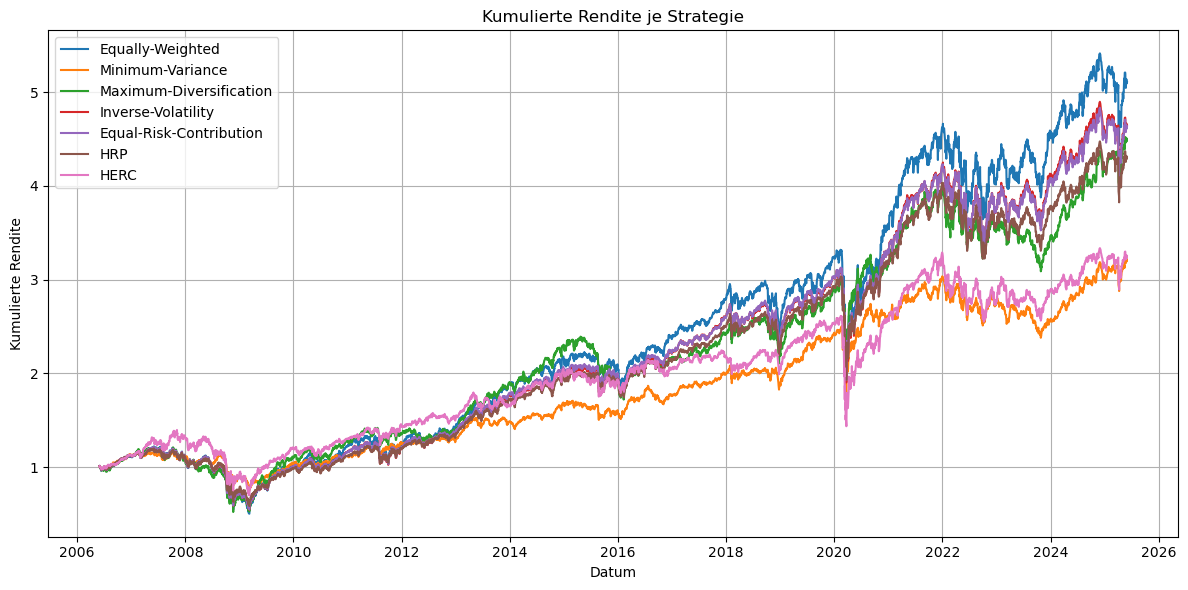

In [82]:
df_SP500_2jahre["Date"] = pd.to_datetime(df_SP500_2jahre["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre = df_SP500_2jahre.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sharpe_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          1.726300          2.804381                 2.105272   
2007          0.057342         -0.126282                -0.221306   
2008         -0.756156         -0.527269                -0.907135   
2009          1.194809          0.913084                 1.825123   
2010          1.001549          0.789505                 1.093951   
2011          0.139388          0.984078                 0.382928   
2012          1.138696          0.251804                 0.291992   
2013          2.523530          1.668973                 2.883437   
2014          1.109386          1.309832                 1.497925   
2015         -0.182184         -0.317855                -0.988726   
2016          1.008486          1.065527                 0.894884   
2017          2.319445          2.144632                 1.505399   
2018         -0.517067         -0.339221                -0.571586   
2019          2.014488          2.860337                 2.739960   
2020          0.464802          0.404790                 0.439367   
2021          1.895118          1.476983                 2.131338   
2022         -0.443879         -0.593851                -0.608866   
2023          0.912337         -0.610472                -0.219831   
2024          0.943030          2.143036                 2.178691   
2025          0.218332          1.095637                 1.250295   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            1.986040                 1.967015  2.185279  2.404193  
2007            0.014085                 0.012554 -0.027576  0.917504  
2008           -0.774306                -0.780957 -0.817868 -0.654204  
2009            1.154481                 1.166833  1.132858  1.156007  
2010            0.958913                 0.955464  0.944988  0.695356  
2011            0.250173                 0.285833  0.453433  0.716467  
2012            1.119620                 1.116971  1.077948  0.571111  
2013            2.457832                 2.536307  2.545736  0.847178  
2014            1.170541                 1.196597  1.211340  1.870604  
2015           -0.099064                -0.138149 -0.076695 -0.235753  
2016            0.944291                 0.945166  0.884529  0.597787  
2017            2.483476                 2.467999  2.650014  1.012416  
2018           -0.511184                -0.461678 -0.458426 -0.376949  
2019            2.137147                 2.203974  2.338105  2.196482  
2020            0.440233                 0.432430  0.438532  0.260066  
2021            1.971335                 2.064150  2.083246  2.091451  
2022           -0.450641                -0.461538 -0.508622 -0.785826  
2023            0.784637                 0.710867  0.505432  0.341115  
2024            1.035584                 1.082085  1.134285  1.010099  
2025            0.287288                 0.366005  0.427850  0.555027

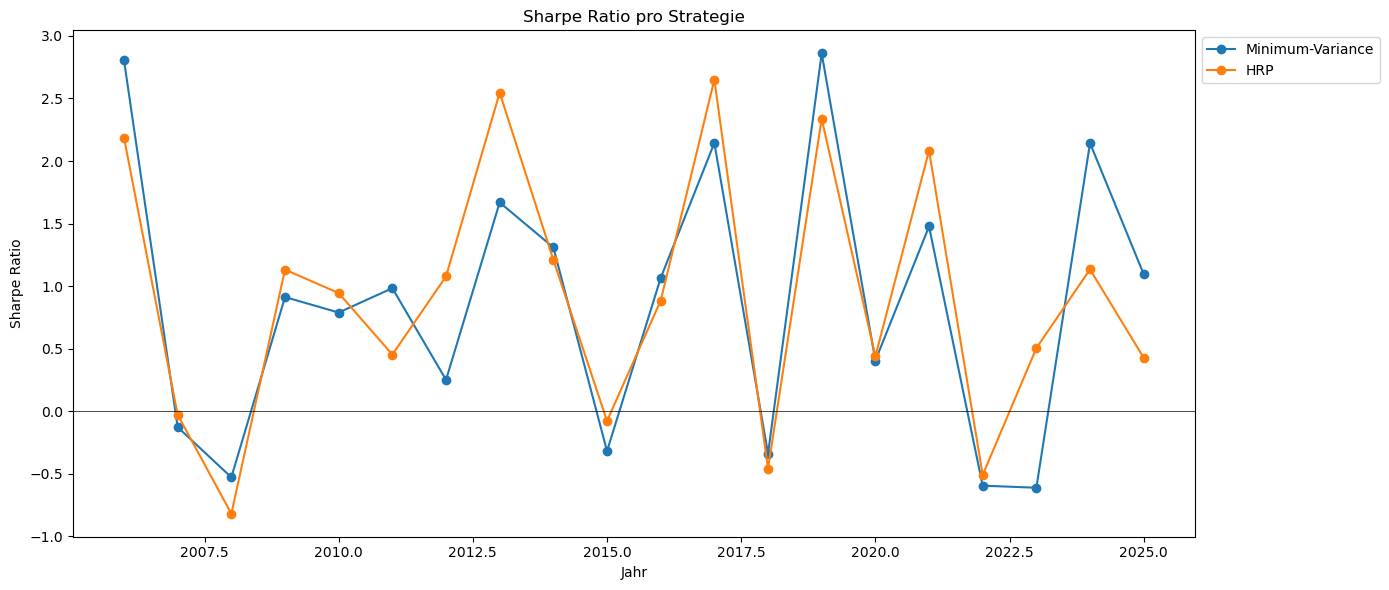

In [84]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre.columns
years = sharpe_jahresweise_2jahre.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

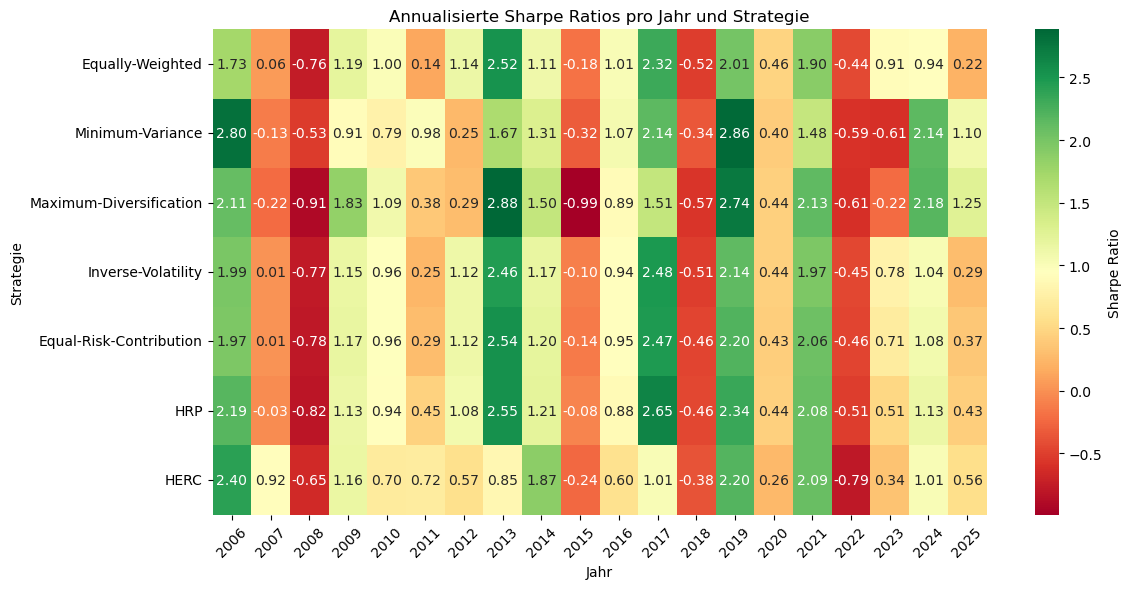

In [85]:
plt.figure(figsize=(12,6))
sb.heatmap(sharpe_jahresweise_2jahre.T,        
            annot=True,                  
            fmt=".2f",                  
            cmap="RdYlGn",               
            cbar_kws={'label': 'Sharpe Ratio'})  

plt.title("Annualisierte Sharpe Ratios pro Jahr und Strategie")
plt.xlabel("Jahr")
plt.ylabel("Strategie")
plt.yticks(rotation=0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [86]:
#Gesamt-Sharpe Ratio für jede Strategie über alle Jahre
def sharpe_annual_2jahre(returns_daily):
    mean_daily = returns_daily.mean()
    std_daily = returns_daily.std()
    return (mean_daily / std_daily) * np.sqrt(252)  # 252 Handelstage

gesamt_sharpe_2jahre = df_SP500_2jahre.apply(sharpe_annual_2jahre)

print(gesamt_sharpe_2jahre)

Equally-Weighted           0.506382
Minimum-Variance           0.511248
Maximum-Diversification    0.529143
Inverse-Volatility         0.509006
Equal-Risk-Contribution    0.513940
HRP                        0.524182
HERC                       0.420528
dtype: float64


In [87]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
sortino_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.785896          4.414262                 3.329689   
2007          0.076222         -0.170889                -0.294362   
2008         -1.042556         -0.770170                -1.229893   
2009          1.784471          1.305795                 2.716618   
2010          1.451815          1.099115                 1.527738   
2011          0.190273          1.407698                 0.532840   
2012          1.720272          0.345233                 0.414218   
2013          3.789068          2.436988                 4.501789   
2014          1.544676          1.879252                 2.190734   
2015         -0.251800         -0.424246                -1.310093   
2016          1.426238          1.553006                 1.309301   
2017          3.623936          3.231437                 2.172030   
2018         -0.672158         -0.441863                -0.753616   
2019          2.904876          4.488483                 4.251302   
2020          0.638398          0.567953                 0.596292   
2021          2.841326          2.201525                 3.215646   
2022         -0.623143         -0.794301                -0.824817   
2023          1.356723         -0.821086                -0.300015   
2024          1.337034          3.232621                 3.405776   
2025          0.320275          1.586351                 1.838362   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.264648                 3.220346  3.613391  4.128932  
2007            0.018687                 0.016603 -0.036475  1.245728  
2008           -1.073187                -1.081725 -1.137708 -0.933806  
2009            1.707258                 1.724585  1.661670  1.712469  
2010            1.387490                 1.378716  1.356878  0.996860  
2011            0.342223                 0.391123  0.621687  1.003972  
2012            1.685541                 1.678353  1.617175  0.859383  
2013            3.717580                 3.836876  3.879841  1.242960  
2014            1.638079                 1.676157  1.693347  2.872855  
2015           -0.137207                -0.190967 -0.106067 -0.319777  
2016            1.334246                 1.340534  1.253026  0.811667  
2017            3.912030                 3.889240  4.189096  1.459108  
2018           -0.661649                -0.598360 -0.591400 -0.495665  
2019            3.091837                 3.199124  3.438032  3.341182  
2020            0.603075                 0.589666  0.597848  0.346427  
2021            2.942268                 3.088290  3.097886  3.105822  
2022           -0.632054                -0.644546 -0.705114 -1.055042  
2023            1.152975                 1.039891  0.729124  0.485094  
2024            1.479071                 1.550225  1.627808  1.423900  
2025            0.417812                 0.534185  0.622309  0.799458

In [88]:
#Funktion für annualisierten Sharpe Ratio
def sortino_annual_2jahre(returns_daily):
    zins_risikofrei = 0
    mean_daily = returns_daily.mean()
    temp = (np.minimum(0, returns_daily - zins_risikofrei))**2
    temp = np.mean(temp)
    downside_dev = np.sqrt(temp)
    return (mean_daily / downside_dev) * np.sqrt(252)  # 252 Handelstage

#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre = df_SP500_2jahre.apply(sortino_annual_2jahre)

print(gesamt_sortino_2jahre)

Equally-Weighted           0.714012
Minimum-Variance           0.724966
Maximum-Diversification    0.739443
Inverse-Volatility         0.715659
Equal-Risk-Contribution    0.721560
HRP                        0.734567
HERC                       0.588121
dtype: float64


In [89]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.052741         -0.032493                -0.059273   
2007         -0.120748         -0.080058                -0.117420   
2008         -0.512454         -0.295776                -0.517135   
2009         -0.330750         -0.169031                -0.254085   
2010         -0.162524         -0.073024                -0.122309   
2011         -0.223416         -0.099599                -0.134725   
2012         -0.110339         -0.046268                -0.109243   
2013         -0.064484         -0.071129                -0.062004   
2014         -0.078196         -0.052302                -0.060113   
2015         -0.126830         -0.119457                -0.214476   
2016         -0.099950         -0.105794                -0.088980   
2017         -0.029257         -0.033924                -0.042833   
2018         -0.197666         -0.122439                -0.192835   
2019         -0.069981         -0.033540                -0.054744   
2020         -0.401717         -0.292498                -0.294692   
2021         -0.063692         -0.064640                -0.059470   
2022         -0.218539         -0.170636                -0.191583   
2023         -0.137702         -0.150555                -0.146580   
2024         -0.073563         -0.058303                -0.062637   
2025         -0.159403         -0.087339                -0.092951   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.045347                -0.046826 -0.040843 -0.037846  
2007           -0.115669                -0.115073 -0.102085 -0.107134  
2008           -0.471471                -0.469850 -0.423884 -0.434385  
2009           -0.295824                -0.293883 -0.262290 -0.266414  
2010           -0.141236                -0.134765 -0.116468 -0.080497  
2011           -0.192352                -0.185806 -0.155405 -0.132742  
2012           -0.087051                -0.084174 -0.064682 -0.072622  
2013           -0.064309                -0.063766 -0.064882 -0.109632  
2014           -0.072009                -0.073350 -0.068150 -0.047514  
2015           -0.114733                -0.115816 -0.106844 -0.142777  
2016           -0.089344                -0.087857 -0.079469 -0.082188  
2017           -0.026086                -0.023031 -0.021804 -0.043010  
2018           -0.185922                -0.181886 -0.173825 -0.115712  
2019           -0.059851                -0.056332 -0.049875 -0.044183  
2020           -0.389382                -0.382620 -0.363213 -0.450138  
2021           -0.057541                -0.055367 -0.058474 -0.058096  
2022           -0.208297                -0.203155 -0.200254 -0.215653  
2023           -0.129102                -0.125488 -0.123757 -0.154171  
2024           -0.073719                -0.071057 -0.067907 -0.065816  
2025           -0.141212                -0.136326 -0.125336 -0.115355

In [90]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
max_drawdown_total_2jahre = df_SP500_2jahre.apply(maximum_drawdown)

max_drawdown_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.587619
Minimum-Variance          -0.349410
Maximum-Diversification   -0.569304
Inverse-Volatility        -0.550472
Equal-Risk-Contribution   -0.549471
HRP                       -0.511302
HERC                      -0.499654
dtype: float64>

In [91]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.164569          4.046097                 2.126167   
2007         -0.036942         -0.267743                -0.353708   
2008         -0.699283         -0.609331                -0.702650   
2009          1.304004          0.833807                 2.351112   
2010          1.213740          1.101241                 1.353829   
2011          0.012436          1.270119                 0.420802   
2012          1.427682          0.348869                 0.245970   
2013          5.326194          2.309725                 6.021450   
2014          1.656690          2.173205                 3.190217   
2015         -0.311041         -0.389833                -0.736132   
2016          1.469096          1.047348                 1.368624   
2017          6.059174          3.888720                 2.897035   
2018         -0.442826         -0.371923                -0.440104   
2019          3.920724          8.387434                 5.776491   
2020          0.275074          0.263515                 0.307053   
2021          4.460225          2.442405                 4.454346   
2022         -0.548410         -0.568721                -0.614226   
2023          0.911186         -0.430103                -0.207092   
2024          1.441920          3.043953                 3.372850   
2025          0.060899          0.753520                 0.893652   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.657177                 2.574646  2.976188  3.385091  
2007           -0.091705                -0.091288 -0.142242  1.600075  
2008           -0.703381                -0.703761 -0.720907 -0.705455  
2009            1.154837                 1.169633  1.057026  1.141136  
2010            1.176658                 1.185654  1.198863  1.091539  
2011            0.163808                 0.214178  0.467865  0.851597  
2012            1.556913                 1.573880  1.697262  0.667458  
2013            4.853993                 4.990951  4.643971  0.890426  
2014            1.821632                 1.830048  1.917215  4.249763  
2015           -0.225740                -0.272463 -0.201977 -0.316215  
2016            1.407718                 1.417723  1.372622  0.890724  
2017            6.719487                 7.335625  8.031016  1.556062  
2018           -0.443318                -0.409468 -0.413133 -0.458645  
2019            4.512152                 4.704335  5.317731  5.119878  
2020            0.253944                 0.248320  0.263377  0.047304  
2021            4.696807                 4.870876  4.377764  4.582726  
2022           -0.537685                -0.540750 -0.553956 -0.725493  
2023            0.761625                 0.674306  0.431267  0.242063  
2024            1.495345                 1.570816  1.630502  1.394363  
2025            0.112301                 0.166141  0.213359  0.312538

In [92]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
calmar_total_2_2jahre = df_SP500_2jahre.apply(calmar_ratio_total)

calmar_total_2_2jahre.info

<bound method Series.info of Equally-Weighted           6.995618
Minimum-Variance           6.347566
Maximum-Diversification    6.146148
Inverse-Volatility         6.627395
Equal-Risk-Contribution    6.609287
HRP                        6.467763
HERC                       4.508484
dtype: float64>

In [93]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.010491         -0.006810                -0.009906   
2007         -0.020285         -0.012582                -0.016718   
2008         -0.047931         -0.033033                -0.047973   
2009         -0.034872         -0.017121                -0.028568   
2010         -0.019340         -0.010670                -0.015887   
2011         -0.027043         -0.011637                -0.020636   
2012         -0.013114         -0.007758                -0.010970   
2013         -0.012294         -0.008546                -0.009969   
2014         -0.012318         -0.009319                -0.012907   
2015         -0.015875         -0.012875                -0.015553   
2016         -0.015644         -0.010956                -0.014255   
2017         -0.006295         -0.005542                -0.007961   
2018         -0.019209         -0.012736                -0.015405   
2019         -0.011889         -0.007521                -0.009835   
2020         -0.035502         -0.022720                -0.024524   
2021         -0.013948         -0.009144                -0.011574   
2022         -0.023715         -0.015496                -0.019138   
2023         -0.014487         -0.011455                -0.012200   
2024         -0.011296         -0.007458                -0.007641   
2025         -0.019304         -0.011496                -0.012638   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.009115                -0.009144 -0.007912 -0.007751  
2007           -0.019888                -0.019556 -0.017554 -0.022562  
2008           -0.043211                -0.042988 -0.039401 -0.041232  
2009           -0.028652                -0.028647 -0.025073 -0.026240  
2010           -0.017464                -0.016856 -0.014565 -0.013808  
2011           -0.023821                -0.023342 -0.019544 -0.015061  
2012           -0.011433                -0.011243 -0.010385 -0.008951  
2013           -0.011051                -0.011087 -0.009917 -0.011657  
2014           -0.011614                -0.011427 -0.011089 -0.009936  
2015           -0.015735                -0.015528 -0.015344 -0.015416  
2016           -0.014511                -0.013958 -0.013997 -0.015494  
2017           -0.005616                -0.005599 -0.005332 -0.007332  
2018           -0.018575                -0.018228 -0.017256 -0.012550  
2019           -0.010665                -0.010225 -0.009566 -0.009333  
2020           -0.032374                -0.031109 -0.029480 -0.033490  
2021           -0.012438                -0.011857 -0.011618 -0.011194  
2022           -0.021999                -0.021575 -0.020028 -0.021366  
2023           -0.014024                -0.013321 -0.012102 -0.014504  
2024           -0.009875                -0.009602 -0.009877 -0.008853  
2025           -0.018060                -0.018126 -0.017394 -0.017124

In [94]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
var_total_2jahre = df_SP500_2jahre.apply(value_at_risk_func)

var_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.019831
Minimum-Variance          -0.012236
Maximum-Diversification   -0.016283
Inverse-Volatility        -0.018135
Equal-Risk-Contribution   -0.017753
HRP                       -0.016067
HERC                      -0.016927
dtype: float64>

In [95]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre = monthly_returns_2jahre.apply(value_at_risk_func)

monthly_var_2jahre.info

<bound method Series.info of Equally-Weighted          -0.080587
Minimum-Variance          -0.049117
Maximum-Diversification   -0.061383
Inverse-Volatility        -0.071151
Equal-Risk-Contribution   -0.068444
HRP                       -0.062326
HERC                      -0.060467
dtype: float64>

In [96]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_jahresweise_2jahre = df_SP500_2jahre.groupby(df_SP500_2jahre.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.013413         -0.009941                -0.012333   
2007         -0.026400         -0.018317                -0.021476   
2008         -0.069082         -0.045209                -0.065899   
2009         -0.049169         -0.022597                -0.038247   
2010         -0.029312         -0.015844                -0.022731   
2011         -0.038661         -0.018411                -0.027065   
2012         -0.018476         -0.010960                -0.015109   
2013         -0.016717         -0.013328                -0.014289   
2014         -0.017560         -0.011943                -0.017348   
2015         -0.022299         -0.018487                -0.023715   
2016         -0.022282         -0.014164                -0.018333   
2017         -0.009541         -0.007956                -0.011163   
2018         -0.025526         -0.018959                -0.021415   
2019         -0.019250         -0.011781                -0.014261   
2020         -0.062003         -0.044896                -0.048693   
2021         -0.019130         -0.013948                -0.015930   
2022         -0.031702         -0.022161                -0.024693   
2023         -0.017592         -0.014691                -0.015288   
2024         -0.016318         -0.010291                -0.011728   
2025         -0.033077         -0.020043                -0.022748   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.011913                -0.012184 -0.010862 -0.010312  
2007           -0.025480                -0.025099 -0.023057 -0.029055  
2008           -0.062969                -0.062515 -0.055569 -0.061610  
2009           -0.041395                -0.041195 -0.034674 -0.038345  
2010           -0.026067                -0.025177 -0.022396 -0.019868  
2011           -0.035276                -0.034459 -0.030148 -0.024640  
2012           -0.016347                -0.016011 -0.013691 -0.010917  
2013           -0.015619                -0.015406 -0.014639 -0.015815  
2014           -0.016663                -0.016632 -0.015975 -0.013018  
2015           -0.021416                -0.021519 -0.020658 -0.022315  
2016           -0.020492                -0.020162 -0.018933 -0.020122  
2017           -0.008831                -0.008553 -0.008249 -0.009219  
2018           -0.024675                -0.024157 -0.023489 -0.019647  
2019           -0.017876                -0.016853 -0.015611 -0.013177  
2020           -0.060227                -0.059074 -0.056110 -0.068872  
2021           -0.018044                -0.017099 -0.016311 -0.016919  
2022           -0.029444                -0.028378 -0.026678 -0.026586  
2023           -0.016691                -0.016070 -0.015246 -0.018170  
2024           -0.014848                -0.014329 -0.013138 -0.012706  
2025           -0.030471                -0.029962 -0.027117 -0.026529

In [97]:
df_SP500_2jahre.index = pd.to_datetime(df_SP500_2jahre.index)
es_total_2jahre = df_SP500_2jahre.apply(expected_shortfall)

es_total_2jahre.info

<bound method Series.info of Equally-Weighted          -0.033254
Minimum-Variance          -0.020465
Maximum-Diversification   -0.027283
Inverse-Volatility        -0.030355
Equal-Risk-Contribution   -0.029806
HRP                       -0.027020
HERC                      -0.029097
dtype: float64>

In [98]:
monthly_returns_2jahre = df_SP500_2jahre.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre  = monthly_returns_2jahre.apply(expected_shortfall)

monthly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.112344
Minimum-Variance          -0.069117
Maximum-Diversification   -0.098403
Inverse-Volatility        -0.102513
Equal-Risk-Contribution   -0.101145
HRP                       -0.092888
HERC                      -0.100743
dtype: float64>

In [99]:
yearly_returns_2jahre = df_SP500_2jahre.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre  = yearly_returns_2jahre.apply(expected_shortfall)

yearly_es_2jahre.info

<bound method Series.info of Equally-Weighted          -0.358351
Minimum-Variance          -0.180225
Maximum-Diversification   -0.363364
Inverse-Volatility        -0.331624
Equal-Risk-Contribution   -0.330662
HRP                       -0.305581
HERC                      -0.306439
dtype: float64>

In [100]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre = pd.concat([gesamt_sharpe_2jahre, gesamt_sortino_2jahre, max_drawdown_total_2jahre, calmar_total_2_2jahre, monthly_var_2jahre, monthly_es_2jahre], axis=1)
Zusammenfassung_2jahre.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var_M", "ES_M"]
print(Zusammenfassung_2jahre)

                           Sharpe   Sortino  Max Drawdown    Calmar     Var_M  \
Equally-Weighted         0.506382  0.714012     -0.587619  6.995618 -0.080587   
Minimum-Variance         0.511248  0.724966     -0.349410  6.347566 -0.049117   
Maximum-Diversification  0.529143  0.739443     -0.569304  6.146148 -0.061383   
Inverse-Volatility       0.509006  0.715659     -0.550472  6.627395 -0.071151   
Equal-Risk-Contribution  0.513940  0.721560     -0.549471  6.609287 -0.068444   
HRP                      0.524182  0.734567     -0.511302  6.467763 -0.062326   
HERC                     0.420528  0.588121     -0.499654  4.508484 -0.060467   

                             ES_M  
Equally-Weighted        -0.112344  
Minimum-Variance        -0.069117  
Maximum-Diversification -0.098403  
Inverse-Volatility      -0.102513  
Equal-Risk-Contribution -0.101145  
HRP                     -0.092888  
HERC                    -0.100743  


## S&P 500 2Jahre Shrinked

In [101]:
#Bearbeitete SP500-Daten (Gesamtbestand, 2 Jahre)

df_SP500_2jahre_shrinked = pd.read_csv(
    'returnssp500shrinked_3Monate_f.csv',
    sep=',',
    encoding='utf-8',
    index_col=0,
    decimal = '.',
    low_memory=False,
    parse_dates=['Date'],
    dayfirst=True
)

In [102]:
df_SP500_2jahre_shrinked.info

<bound method DataFrame.info of             Date  Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
0     2006-06-01          0.012900          0.010584                 0.010986   
1     2006-06-02          0.001590          0.000545                 0.001427   
2     2006-06-05         -0.019401         -0.011641                -0.015187   
3     2006-06-06         -0.002777          0.002887                -0.002299   
4     2006-06-07         -0.005689         -0.000096                -0.000634   
...          ...               ...               ...                      ...   
4775  2025-05-23         -0.003498         -0.000404                -0.000058   
4776  2025-05-27          0.018283          0.012447                 0.010611   
4777  2025-05-28         -0.008828         -0.006128                -0.007216   
4778  2025-05-29          0.003769          0.002484                 0.001074   
4779  2025-05-30         -0.000338          0.004489                 0.004538

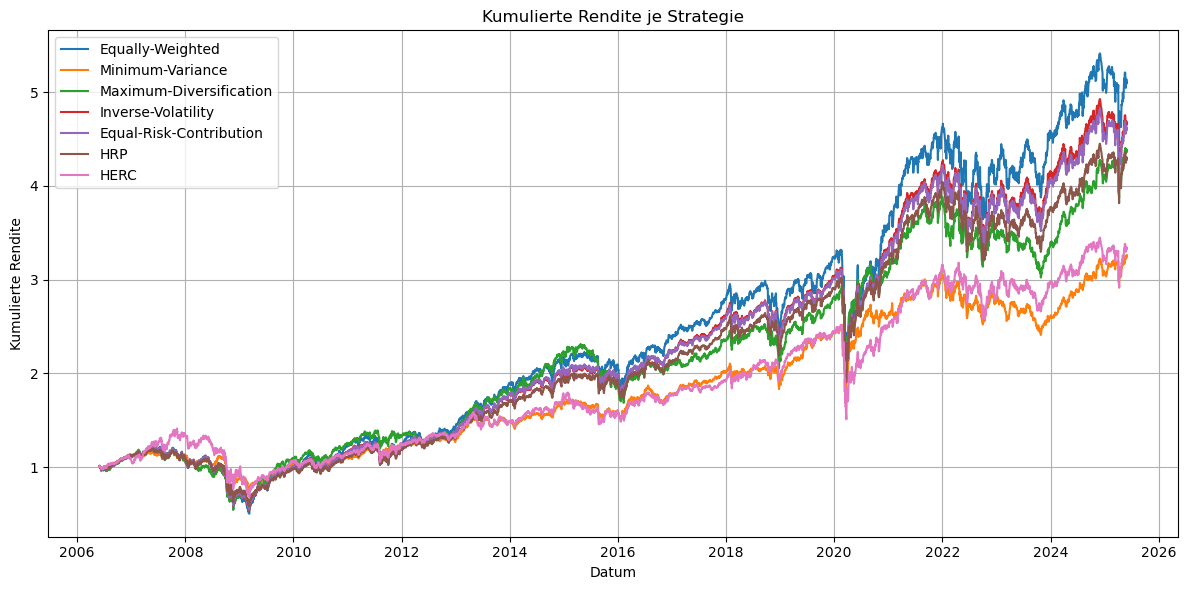

In [103]:
df_SP500_2jahre_shrinked["Date"] = pd.to_datetime(df_SP500_2jahre_shrinked["Date"])

#Date-Spalte als Index setzen
df_SP500_2jahre_shrinked = df_SP500_2jahre_shrinked.set_index("Date")

#Kumulierte Rendite berechnen (angenommen tägliche Returns)
#(1 + r).cumprod() - 1 ergibt den Gesamtzuwachs in Prozent
kumulative_returns = gesamt_return(df_SP500_2jahre_shrinked)

#Plot
plt.figure(figsize=(12,6))
plt.plot(kumulative_returns)
plt.title("Kumulierte Rendite je Strategie")
plt.xlabel("Datum")
plt.ylabel("Kumulierte Rendite")
plt.legend(kumulative_returns.columns, loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [104]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sharpe_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sharpe_ratio(y) * np.sqrt(252)))

sharpe_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          1.726300          2.891414                 2.139823   
2007          0.057342         -0.055554                -0.206031   
2008         -0.756156         -0.610588                -0.883807   
2009          1.194809          0.911242                 1.782475   
2010          1.001549          0.803808                 1.083712   
2011          0.139388          1.025466                 0.394498   
2012          1.138696          0.379517                 0.277360   
2013          2.523530          1.681843                 2.833362   
2014          1.109386          1.403377                 1.535541   
2015         -0.182184         -0.378969                -0.974756   
2016          1.008486          1.124372                 0.905913   
2017          2.319445          2.272840                 1.522465   
2018         -0.517067         -0.412598                -0.557770   
2019          2.014488          2.938702                 2.739914   
2020          0.464802          0.383599                 0.443479   
2021          1.895118          1.536138                 2.161004   
2022         -0.443879         -0.588302                -0.573442   
2023          0.912337         -0.566157                -0.190268   
2024          0.943030          2.150143                 2.228306   
2025          0.218332          1.085442                 1.157288   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            1.961143                 1.910786  2.186964  1.562430  
2007            0.018461                 0.018911 -0.028740  1.155344  
2008           -0.774170                -0.782656 -0.827917 -0.559123  
2009            1.154329                 1.166837  1.134592  0.474927  
2010            0.960035                 0.954107  0.919398  0.637058  
2011            0.243441                 0.285811  0.440440  0.568242  
2012            1.122724                 1.117025  1.086087  0.687317  
2013            2.463741                 2.536253  2.566419  1.081368  
2014            1.165162                 1.196645  1.211576  1.474069  
2015           -0.102917                -0.142557 -0.053776 -0.487541  
2016            0.946073                 0.930123  0.880546  0.966441  
2017            2.482333                 2.467767  2.586405  1.284012  
2018           -0.508267                -0.472190 -0.424880  0.358026  
2019            2.127863                 2.203118  2.326094  2.235760  
2020            0.442736                 0.438716  0.453354  0.263357  
2021            1.966043                 2.067107  2.101057  1.966770  
2022           -0.451115                -0.461509 -0.533172 -0.512112  
2023            0.791638                 0.710915  0.509844  0.453111  
2024            1.028548                 1.074301  1.109113  0.914329  
2025            0.274352                 0.359495  0.453578  0.515115

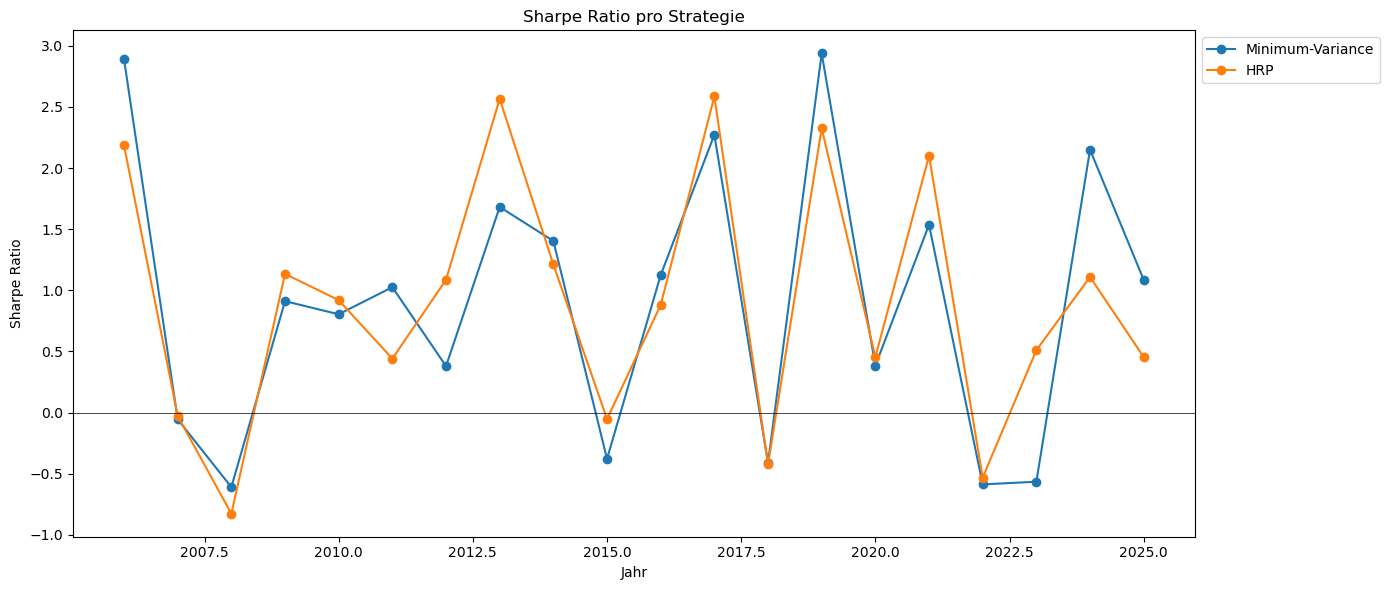

In [105]:
#Plotten der SR
strategien = sharpe_jahresweise_2jahre_shrinked.columns
years = sharpe_jahresweise_2jahre_shrinked.index

plt.figure(figsize=(14,6))

strategie = "Minimum-Variance"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

strategie = "HRP"
plt.plot(years, sharpe_jahresweise_2jahre_shrinked[strategie], label=strategie, marker='o')

plt.axhline(0, color='black', linewidth=0.5)  
plt.xlabel("Jahr")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio pro Strategie")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [106]:
gesamt_sharpe_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sharpe_annual_2jahre)

print(gesamt_sharpe_2jahre_shrinked)

Equally-Weighted           0.506382
Minimum-Variance           0.517786
Maximum-Diversification    0.531912
Inverse-Volatility         0.508453
Equal-Risk-Contribution    0.512608
HRP                        0.523616
HERC                       0.428166
dtype: float64


In [107]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
sortino_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(lambda y: sortino_ratio(y) * np.sqrt(252)))

sortino_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.785896          4.677631                 3.389281   
2007          0.076222         -0.075114                -0.273740   
2008         -1.042556         -0.884241                -1.205283   
2009          1.784471          1.301234                 2.632860   
2010          1.451815          1.120358                 1.514468   
2011          0.190273          1.468886                 0.547223   
2012          1.720272          0.527679                 0.394038   
2013          3.789068          2.457724                 4.410438   
2014          1.544676          2.020155                 2.244497   
2015         -0.251800         -0.505091                -1.291150   
2016          1.426238          1.646943                 1.328070   
2017          3.623936          3.429238                 2.205201   
2018         -0.672158         -0.535032                -0.732212   
2019          2.904876          4.632990                 4.239134   
2020          0.638398          0.536737                 0.601144   
2021          2.841326          2.282614                 3.272690   
2022         -0.623143         -0.787846                -0.778167   
2023          1.356723         -0.763735                -0.259521   
2024          1.337034          3.238082                 3.490639   
2025          0.320275          1.574350                 1.700614   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            3.219443                 3.125214  3.616331  2.416387  
2007            0.024493                 0.025006 -0.038008  1.578108  
2008           -1.072514                -1.083973 -1.152216 -0.793272  
2009            1.707313                 1.724598  1.663744  0.654611  
2010            1.389132                 1.376483  1.317716  0.908748  
2011            0.333016                 0.391095  0.603906  0.786178  
2012            1.690595                 1.678441  1.630140  1.032889  
2013            3.724669                 3.836772  3.919160  1.585892  
2014            1.629825                 1.676235  1.693508  2.150158  
2015           -0.142527                -0.196998 -0.074361 -0.647086  
2016            1.336688                 1.316971  1.245642  1.366616  
2017            3.909369                 3.888759  4.089416  1.901114  
2018           -0.658111                -0.611832 -0.548286  0.463669  
2019            3.077309                 3.198219  3.415077  3.380286  
2020            0.606609                 0.598851  0.619311  0.355460  
2021            2.935415                 3.091558  3.122750  2.909225  
2022           -0.632735                -0.644509 -0.738452 -0.709640  
2023            1.164013                 1.039967  0.736698  0.655096  
2024            1.468268                 1.537728  1.588343  1.274392  
2025            0.399461                 0.524657  0.658169  0.754230

In [108]:
#Gesamt-Sortino Ratio für jede Strategie über alle Jahre
gesamt_sortino_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(sortino_annual_2jahre)

print(gesamt_sortino_2jahre_shrinked)

Equally-Weighted           0.714012
Minimum-Variance           0.732622
Maximum-Diversification    0.742991
Inverse-Volatility         0.714942
Equal-Risk-Contribution    0.719747
HRP                        0.734005
HERC                       0.597087
dtype: float64


In [109]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(maximum_drawdown))

max_drawdown_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.052741         -0.032279                -0.054051   
2007         -0.120748         -0.076491                -0.112021   
2008         -0.512454         -0.301771                -0.494789   
2009         -0.330750         -0.164424                -0.242620   
2010         -0.162524         -0.072580                -0.120688   
2011         -0.223416         -0.098084                -0.133020   
2012         -0.110339         -0.045283                -0.099243   
2013         -0.064484         -0.072022                -0.062473   
2014         -0.078196         -0.051502                -0.058750   
2015         -0.126830         -0.122535                -0.207928   
2016         -0.099950         -0.102278                -0.085324   
2017         -0.029257         -0.033179                -0.040021   
2018         -0.197666         -0.129443                -0.186666   
2019         -0.069981         -0.033791                -0.051471   
2020         -0.401717         -0.293385                -0.296597   
2021         -0.063692         -0.064956                -0.058448   
2022         -0.218539         -0.173548                -0.188080   
2023         -0.137702         -0.147538                -0.144207   
2024         -0.073563         -0.056281                -0.058968   
2025         -0.159403         -0.090116                -0.093105   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.046101                -0.048022 -0.039830 -0.038872  
2007           -0.116415                -0.115185 -0.102662 -0.112786  
2008           -0.474809                -0.470290 -0.424820 -0.426131  
2009           -0.298225                -0.293925 -0.262508 -0.324564  
2010           -0.142686                -0.135039 -0.116189 -0.084843  
2011           -0.194586                -0.185817 -0.156942 -0.154221  
2012           -0.088007                -0.084186 -0.063927 -0.064096  
2013           -0.064234                -0.063766 -0.063892 -0.117818  
2014           -0.072522                -0.073350 -0.066951 -0.050033  
2015           -0.115345                -0.115823 -0.105844 -0.188401  
2016           -0.089940                -0.089762 -0.077905 -0.075259  
2017           -0.026411                -0.023038 -0.023703 -0.045610  
2018           -0.187180                -0.184657 -0.173098 -0.109660  
2019           -0.060545                -0.056327 -0.048965 -0.033817  
2020           -0.390069                -0.382474 -0.360998 -0.399772  
2021           -0.058111                -0.056028 -0.058486 -0.067351  
2022           -0.209021                -0.203160 -0.205611 -0.189520  
2023           -0.129462                -0.125495 -0.122172 -0.139431  
2024           -0.073858                -0.071814 -0.068031 -0.074943  
2025           -0.143711                -0.136920 -0.124653 -0.133234

In [110]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
max_drawdown_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(maximum_drawdown)

max_drawdown_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.587619
Minimum-Variance          -0.355833
Maximum-Diversification   -0.547623
Inverse-Volatility        -0.553374
Equal-Risk-Contribution   -0.549903
HRP                       -0.513826
HERC                      -0.517312
dtype: float64>

In [111]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(calmar_ratio_total))

calmar_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006          2.164569          4.103533                 2.293935   
2007         -0.036942         -0.173812                -0.344699   
2008         -0.699283         -0.655387                -0.697424   
2009          1.304004          0.831708                 2.188904   
2010          1.213740          1.136124                 1.323150   
2011          0.012436          1.353461                 0.431741   
2012          1.427682          0.563262                 0.245674   
2013          5.326194          2.275204                 5.729477   
2014          1.656690          2.387743                 3.278851   
2015         -0.311041         -0.441526                -0.738746   
2016          1.469096          1.139110                 1.429614   
2017          6.059174          4.168357                 3.003683   
2018         -0.442826         -0.414872                -0.436240   
2019          3.920724          8.527925                 6.045766   
2020          0.275074          0.241572                 0.308597   
2021          4.460225          2.530946                 4.450040   
2022         -0.548410         -0.555293                -0.590918   
2023          0.911186         -0.405616                -0.185132   
2024          1.441920          3.140359                 3.605262   
2025          0.060899          0.731168                 0.811402   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006            2.605014                 2.477880  3.049999  2.308917  
2007           -0.085936                -0.082925 -0.144214  2.082677  
2008           -0.703032                -0.704227 -0.726169 -0.667380  
2009            1.158531                 1.169690  1.054013  0.298496  
2010            1.175492                 1.182844  1.162844  0.944745  
2011            0.153715                 0.214141  0.448461  0.619056  
2012            1.554315                 1.573853  1.725353  0.905843  
2013            4.895143                 4.991128  4.769308  1.101765  
2014            1.806263                 1.830039  1.947138  3.146492  
2015           -0.229981                -0.278259 -0.172776 -0.452350  
2016            1.406920                 1.365983  1.389153  1.578999  
2017            6.696436                 7.333233  7.187091  1.800931  
2018           -0.441172                -0.414524 -0.386097  0.359731  
2019            4.466023                 4.704503  5.386206  6.832970  
2020            0.256332                 0.255132  0.280050  0.071805  
2021            4.669270                 4.836563  4.432511  3.744769  
2022           -0.538431                -0.540735 -0.561373 -0.547794  
2023            0.769663                 0.674345  0.439937  0.352183  
2024            1.489751                 1.543683  1.597158  1.136488  
2025            0.102753                 0.161273  0.231725  0.269546

In [112]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
calmar_total_2_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(calmar_ratio_total)

calmar_total_2_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted           6.995618
Minimum-Variance           6.353367
Maximum-Diversification    6.177837
Inverse-Volatility         6.634490
Equal-Risk-Contribution    6.572539
HRP                        6.414539
HERC                       4.517458
dtype: float64>

In [113]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(value_at_risk_func))

var_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.010491         -0.007114                -0.009850   
2007         -0.020285         -0.012892                -0.016598   
2008         -0.047931         -0.032270                -0.046814   
2009         -0.034872         -0.017005                -0.026856   
2010         -0.019340         -0.010597                -0.015197   
2011         -0.027043         -0.011253                -0.018952   
2012         -0.013114         -0.007765                -0.010464   
2013         -0.012294         -0.008787                -0.009783   
2014         -0.012318         -0.009382                -0.012579   
2015         -0.015875         -0.012928                -0.015347   
2016         -0.015644         -0.010851                -0.014093   
2017         -0.006295         -0.005393                -0.007891   
2018         -0.019209         -0.013114                -0.015292   
2019         -0.011889         -0.007413                -0.009376   
2020         -0.035502         -0.022024                -0.023979   
2021         -0.013948         -0.009037                -0.011042   
2022         -0.023715         -0.015344                -0.018994   
2023         -0.014487         -0.010593                -0.011802   
2024         -0.011296         -0.007345                -0.007657   
2025         -0.019304         -0.011654                -0.011556   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.009176                -0.009221 -0.007832 -0.008761  
2007           -0.019964                -0.019673 -0.017723 -0.023128  
2008           -0.043638                -0.042994 -0.039236 -0.043837  
2009           -0.028963                -0.028652 -0.025052 -0.029222  
2010           -0.017633                -0.016867 -0.014437 -0.014089  
2011           -0.024086                -0.023345 -0.019726 -0.017005  
2012           -0.011494                -0.011243 -0.010216 -0.008458  
2013           -0.011154                -0.011089 -0.009768 -0.011996  
2014           -0.011673                -0.011426 -0.011070 -0.010362  
2015           -0.015773                -0.015649 -0.015145 -0.016117  
2016           -0.014535                -0.014252 -0.013900 -0.013152  
2017           -0.005660                -0.005599 -0.005212 -0.006441  
2018           -0.018739                -0.018229 -0.017143 -0.011933  
2019           -0.010773                -0.010228 -0.009615 -0.008820  
2020           -0.032505                -0.031468 -0.029615 -0.031894  
2021           -0.012583                -0.011901 -0.011613 -0.011285  
2022           -0.022102                -0.021577 -0.020070 -0.018303  
2023           -0.014055                -0.013321 -0.012006 -0.013212  
2024           -0.010015                -0.009603 -0.009747 -0.009122  
2025           -0.018331                -0.018128 -0.017188 -0.017316

In [114]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
var_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(value_at_risk_func)

var_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.019831
Minimum-Variance          -0.012203
Maximum-Diversification   -0.015746
Inverse-Volatility        -0.018272
Equal-Risk-Contribution   -0.017753
HRP                       -0.016146
HERC                      -0.016459
dtype: float64>

In [115]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_var_2jahre_shrinked = monthly_returns_2jahre_shrinked.apply(value_at_risk_func)

monthly_var_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.080587
Minimum-Variance          -0.048589
Maximum-Diversification   -0.060136
Inverse-Volatility        -0.072115
Equal-Risk-Contribution   -0.068467
HRP                       -0.061876
HERC                      -0.062251
dtype: float64>

In [116]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_jahresweise_2jahre_shrinked = df_SP500_2jahre_shrinked.groupby(df_SP500_2jahre_shrinked.index.year).apply(lambda x: x.apply(expected_shortfall))

es_jahresweise_2jahre_shrinked

Equally-Weighted  Minimum-Variance  Maximum-Diversification  \
Date                                                                
2006         -0.013413         -0.009300                -0.011849   
2007         -0.026400         -0.018167                -0.021205   
2008         -0.069082         -0.044855                -0.063207   
2009         -0.049169         -0.021638                -0.035463   
2010         -0.029312         -0.015817                -0.022236   
2011         -0.038661         -0.018364                -0.026143   
2012         -0.018476         -0.010644                -0.014432   
2013         -0.016717         -0.013155                -0.013979   
2014         -0.017560         -0.011999                -0.016991   
2015         -0.022299         -0.018674                -0.023427   
2016         -0.022282         -0.013851                -0.017974   
2017         -0.009541         -0.007991                -0.010613   
2018         -0.025526         -0.018974                -0.021234   
2019         -0.019250         -0.011835                -0.014160   
2020         -0.062003         -0.045269                -0.048377   
2021         -0.019130         -0.014051                -0.015327   
2022         -0.031702         -0.022120                -0.024599   
2023         -0.017592         -0.014406                -0.015171   
2024         -0.016318         -0.010284                -0.011500   
2025         -0.033077         -0.020416                -0.022331   

      Inverse-Volatility  Equal-Risk-Contribution       HRP      HERC  
Date                                                                   
2006           -0.012051                -0.012447 -0.010825 -0.012947  
2007           -0.025579                -0.025172 -0.023167 -0.029951  
2008           -0.063414                -0.062522 -0.055663 -0.063988  
2009           -0.041889                -0.041202 -0.034472 -0.043740  
2010           -0.026276                -0.025226 -0.022405 -0.020271  
2011           -0.035527                -0.034460 -0.030454 -0.029010  
2012           -0.016445                -0.016012 -0.013583 -0.010816  
2013           -0.015694                -0.015407 -0.014629 -0.016130  
2014           -0.016736                -0.016632 -0.015979 -0.014445  
2015           -0.021460                -0.021546 -0.020644 -0.024410  
2016           -0.020585                -0.020287 -0.018833 -0.017820  
2017           -0.008905                -0.008553 -0.008221 -0.008503  
2018           -0.024799                -0.024328 -0.023381 -0.022363  
2019           -0.017978                -0.016853 -0.015637 -0.013500  
2020           -0.060336                -0.059019 -0.055701 -0.061160  
2021           -0.018137                -0.017172 -0.016394 -0.016637  
2022           -0.029561                -0.028379 -0.026764 -0.023997  
2023           -0.016731                -0.016070 -0.015208 -0.015996  
2024           -0.014968                -0.014352 -0.013244 -0.013463  
2025           -0.030875                -0.029964 -0.027256 -0.029532

In [117]:
df_SP500_2jahre_shrinked.index = pd.to_datetime(df_SP500_2jahre_shrinked.index)
es_total_2jahre_shrinked = df_SP500_2jahre_shrinked.apply(expected_shortfall)

es_total_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.033254
Minimum-Variance          -0.020415
Maximum-Diversification   -0.026468
Inverse-Volatility        -0.030552
Equal-Risk-Contribution   -0.029841
HRP                       -0.027018
HERC                      -0.029363
dtype: float64>

In [118]:
monthly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_es_2jahre_shrinked  = monthly_returns_2jahre_shrinked.apply(expected_shortfall)

monthly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.112344
Minimum-Variance          -0.070473
Maximum-Diversification   -0.095114
Inverse-Volatility        -0.103203
Equal-Risk-Contribution   -0.101070
HRP                       -0.092790
HERC                      -0.100387
dtype: float64>

In [119]:
yearly_returns_2jahre_shrinked = df_SP500_2jahre_shrinked.resample('Y').apply(lambda x: (1 + x).prod() - 1)
yearly_es_2jahre_shrinked  = yearly_returns_2jahre_shrinked.apply(expected_shortfall)

yearly_es_2jahre_shrinked.info

<bound method Series.info of Equally-Weighted          -0.358351
Minimum-Variance          -0.197777
Maximum-Diversification   -0.345077
Inverse-Volatility        -0.333805
Equal-Risk-Contribution   -0.331191
HRP                       -0.308491
HERC                      -0.284391
dtype: float64>

In [120]:
#Zusammenfassung der Metriken
Zusammenfassung_2jahre_shrinked = pd.concat([gesamt_sharpe_2jahre_shrinked, gesamt_sortino_2jahre_shrinked, max_drawdown_total_2jahre_shrinked, calmar_total_2_2jahre_shrinked, monthly_var_2jahre_shrinked, monthly_es_2jahre_shrinked], axis=1)
Zusammenfassung_2jahre_shrinked.columns = ["Sharpe","Sortino", "Max Drawdown", "Calmar", "Var", "ES"]
print(Zusammenfassung_2jahre_shrinked)

                           Sharpe   Sortino  Max Drawdown    Calmar       Var  \
Equally-Weighted         0.506382  0.714012     -0.587619  6.995618 -0.080587   
Minimum-Variance         0.517786  0.732622     -0.355833  6.353367 -0.048589   
Maximum-Diversification  0.531912  0.742991     -0.547623  6.177837 -0.060136   
Inverse-Volatility       0.508453  0.714942     -0.553374  6.634490 -0.072115   
Equal-Risk-Contribution  0.512608  0.719747     -0.549903  6.572539 -0.068467   
HRP                      0.523616  0.734005     -0.513826  6.414539 -0.061876   
HERC                     0.428166  0.597087     -0.517312  4.517458 -0.062251   

                               ES  
Equally-Weighted        -0.112344  
Minimum-Variance        -0.070473  
Maximum-Diversification -0.095114  
Inverse-Volatility      -0.103203  
Equal-Risk-Contribution -0.101070  
HRP                     -0.092790  
HERC                    -0.100387  


## S&P500 3 Jahre